In [1]:
import pandas as pd
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import LeaveOneOut
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns  # Opcional, para estilização
from sklearn.metrics import explained_variance_score
from sklearn.linear_model import LinearRegression


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\lenau\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\lenau\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\lenau\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_lo

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\lenau\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\lenau\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\lenau\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_lo

AttributeError: _ARRAY_API not found

In [2]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Definindo o caminho base para a pasta Pre-processamento
base_path = Path(parent_dir) / 'PCA_Keitt'

file_path_raw_cal = base_path / 'RAW_calibration.xlsx'
file_path_msc_cal = base_path / 'MSC_calibration.xlsx'
file_path_snv_cal = base_path / 'SNV_calibration.xlsx'
file_path_sg_cal = base_path / 'SG_calibration.xlsx'

df_raw_cal = pd.read_excel(file_path_raw_cal)
df_msc_cal = pd.read_excel(file_path_msc_cal)
df_snv_cal = pd.read_excel(file_path_snv_cal)
df_sg_cal = pd.read_excel(file_path_sg_cal)

file_path_raw_val = base_path / 'RAW_validation.xlsx'
file_path_msc_val = base_path / 'MSC_validation.xlsx'
file_path_snv_val = base_path / 'SNV_validation.xlsx'
file_path_sg_val = base_path / 'SG_validation.xlsx'

df_raw_val = pd.read_excel(file_path_raw_val)
df_msc_val = pd.read_excel(file_path_msc_val)
df_snv_val = pd.read_excel(file_path_snv_val)
df_sg_val = pd.read_excel(file_path_sg_val)

In [8]:
def choose_optimal_lv(validation, calibration, pls_model, max_lv, X_scaled, Y_scaled):
    """
    Escolhe o número ótimo de componentes latentes (LV) com base nas métricas de calibração e validação cruzada.
    
    Args:
        calibration (pd.DataFrame): DataFrame contendo as métricas de calibração.
        validation (pd.DataFrame): DataFrame contendo as métricas de validação cruzada.
        max_lv (int): Número máximo de LVs a serem considerados.

    Returns:
        int: Número ótimo de LVs.
    """
    lvs = []
    k = 1
    
    for j in range(1, max_lv):
        if j + 1 <= max_lv:
            rpearson_cal_j = calibration.loc[j + 1, 'rpearson_cal']
            rpearson_cv_j = validation.loc[j + 1, 'rpearson_cv']
            rpearson_cal_j_plus_1 = calibration.loc[j, 'rpearson_cal']
            rpearson_cv_j_plus_1 = validation.loc[j, 'rpearson_cv']
            
            # Verifica se há uma melhora em ambas as métricas rpearson (calibração e validação cruzada)
            aux_cal = rpearson_cal_j / rpearson_cal_j_plus_1
            aux_cv = rpearson_cv_j / rpearson_cv_j_plus_1
            
            # Critério: Aumenta o LV se houver uma melhora significativa em ambas as métricas
            if aux_cal > 1 and aux_cv > 1 and ((aux_cv - 1) * 100 >= 2):
                lvs.append(j + 1)
                k += 1

    # Se nenhum LV for selecionado, use o primeiro por padrão
    if len(lvs) == 0:
        return 1

    lv_num = lvs[-1]  # Inicialmente, assume-se o maior LV selecionado

    if len(lvs) > 1:
        pls_model = PLSRegression(n_components=lvs[-2])
        pls_model.fit(X_scaled, Y_scaled)

        # Avalia a estabilidade dos coeficientes do modelo
        for w in range(k - 2):
            if pls_model.coef_.shape[1] > 3:
                if lvs[w + 1] < pls_model.coef_.shape[0] and pls_model.coef_[lvs[w + 1], 3] < 1:
                    lv_num = lvs[w]
                    break

    return lv_num

def train_model(X_scaled, Y_scaled):
    max_lv = 10
    loo = LeaveOneOut()

    calibration = pd.DataFrame(index=range(1, max_lv + 1), columns=['r2_cal', 'neg_root_mean_squared_error_cal', 'explained_variance_cal', 'correlation_cal', 'rpearson_cal', 'secv_cal'])
    validation = pd.DataFrame(index=range(1, max_lv + 1), columns=['r2_cv', 'neg_root_mean_squared_error_cv', 'explained_variance_cv', 'correlation_cv', 'rpearson_cv', 'secv_cv'])
    
    Y_values = pd.DataFrame(index=range(len(Y_scaled)))
    Y_values['Referencia'] = Y_scaled.flatten()  # Valores reais de Y
        
    for lv in range(1, max_lv + 1):
        pls_model = PLSRegression(n_components=lv, max_iter=500)

        # Calibração do modelo
        pls_model.fit(X_scaled, Y_scaled)
        predictions_train = pls_model.predict(X_scaled)

        # Calcula as métricas para a fase de calibração
        calibration.loc[lv, 'r2_cal'] = r2_score(Y_scaled, predictions_train)
        calibration.loc[lv, 'neg_root_mean_squared_error_cal'] = np.sqrt(mean_squared_error(Y_scaled, predictions_train))
        calibration.loc[lv, 'explained_variance_cal'] = explained_variance_score(Y_scaled, predictions_train)

        # Garantir que Y_scaled e predictions_train sejam arrays bidimensionais
        if Y_scaled.ndim == 1:
            Y_scaled = Y_scaled.reshape(-1, 1)
        if predictions_train.ndim == 1:
            predictions_train = predictions_train.reshape(-1, 1)

        correlation_cal = np.corrcoef(Y_scaled[:, 0], predictions_train[:, 0])[0, 1]  # Correlação
        calibration.loc[lv, 'correlation_cal'] = correlation_cal

        # Calcular rpearson para calibração
        rpearson_cal = correlation_cal ** 2
        calibration.loc[lv, 'rpearson_cal'] = rpearson_cal

        # Calcular o viés para calibração
        bias_cal = np.mean(predictions_train - Y_scaled)
        calibration.loc[lv, 'bias_cal'] = bias_cal

        # Calcular SE (Standard Error) para calibração
        sec_cal = np.sqrt(mean_squared_error(Y_scaled, predictions_train))
        calibration.loc[lv, 'sec_cal'] = sec_cal
        
        # Adicionar as previsões de calibração ao DataFrame Y_values
        Y_values[f'Calibracao_LV{lv}'] = predictions_train.flatten()

        # Validação cruzada (Leave-One-Out)
        predictions_cv = cross_val_predict(pls_model, X_scaled, Y_scaled, cv=loo)

        # Calcula as métricas para a validação cruzada
        validation.loc[lv, 'r2_cv'] = r2_score(Y_scaled, predictions_cv)
        validation.loc[lv, 'neg_root_mean_squared_error_cv'] = np.sqrt(mean_squared_error(Y_scaled, predictions_cv))
        validation.loc[lv, 'explained_variance_cv'] = explained_variance_score(Y_scaled, predictions_cv)

        # Garantir que predictions_cv seja array bidimensional
        if predictions_cv.ndim == 1:
            predictions_cv = predictions_cv.reshape(-1, 1)

        correlation_cv = np.corrcoef(Y_scaled[:, 0], predictions_cv[:, 0])[0, 1]  # Correlação
        validation.loc[lv, 'correlation_cv'] = correlation_cv

        # Calcular rpearson para validação cruzada
        rpearson_cv = correlation_cv ** 2
        validation.loc[lv, 'rpearson_cv'] = rpearson_cv

        # Calcular o viés para validação cruzada
        bias_cv = np.mean(predictions_cv - Y_scaled)
        validation.loc[lv, 'bias_cv'] = bias_cv

        # Calcular SECV (Standard Error of Cross Validation)
        secv_cv = np.sqrt(mean_squared_error(Y_scaled, predictions_cv))
        validation.loc[lv, 'secv_cv'] = secv_cv
        
        # Adicionar as previsões de validação ao DataFrame Y_values
        Y_values[f'Validacao_LV{lv}'] = predictions_cv.flatten()
    
    # Escolha o LV ótimo
    optimal_lv = choose_optimal_lv(validation, calibration, pls_model, max_lv, X_scaled, Y_scaled)
    
    # Treina o modelo final com o LV ótimo
    model = PLSRegression(n_components=optimal_lv)
    model.fit(X_scaled, Y_scaled)
    
    return calibration, validation, optimal_lv, model, Y_values


def center_data(X, Y):
    # Calcula as médias para cada coluna
    mx = np.mean(X, axis=0)
    
    # Calcula a média para Y
    my = np.mean(Y)
    
    # Centraliza as colunas na média
    abs_centered = X - mx
    qua_centered = Y - my
       
    return abs_centered, qua_centered, mx, my

def predict(model, X_pred, y_pred, lv_number):
    X_centered, _, _, _ = center_data(X_pred.iloc[:,7:].values, y_pred.values)
    pred = model.predict(X_pred.iloc[:,7:].values)
       
    y_pred = y_pred.values  # Convertendo Series para NumPy array
    pred = pred.reshape(-1, 1)  # Garantindo que pred seja 2D

    if y_pred.ndim == 1:
        y_pred = y_pred.reshape(-1, 1)

    Y_predict = pd.DataFrame(columns=['Amostra', 'Y_pred', 'Y_true', 'Deviation'])
    
    prediction = pd.DataFrame(columns=['r2_cv', 'neg_root_mean_squared_error_cv', 'explained_variance_cv', 'correlation_cv', 'rpearson_cv', 'bias_cv', 'secv_cv'])
    
    prediction.loc[lv_number, 'r2_p'] = r2_score(y_pred, pred)
    prediction.loc[lv_number, 'neg_root_mean_squared_error_p'] = np.sqrt(mean_squared_error(y_pred, pred))
    prediction.loc[lv_number, 'explained_variance_p'] = explained_variance_score(y_pred, pred)
    prediction.loc[lv_number, 'correlation_p'] = np.corrcoef(y_pred[:, 0], pred[:, 0])[0, 1]
    prediction.loc[lv_number, 'rpearson_p'] = np.corrcoef(y_pred[:, 0], pred[:, 0])[0, 1] ** 2  # Quadrado do coeficiente de correlação
    prediction.loc[lv_number, 'bias_p'] = np.mean(pred - y_pred)  # Viés
    prediction.loc[lv_number, 'sec_p'] = np.sqrt(np.mean((pred - y_pred) ** 2))  # Erro quadrático de calibração
    
    Y_predict['Y_pred'] = pred.flatten()
    Y_predict['Y_true'] = y_pred.flatten()
    Y_predict['Deviation'] = pred.flatten() - y_pred.flatten()
    Y_predict['Amostra'] = X_pred.iloc[0:,0].tolist()
        
    return prediction, Y_predict

def plot_pred_vs_ref(Y_true, Y_pred, Y_opt, title="Predicted vs Reference"):
    
    slope_pred, offset_pred = np.polyfit(Y_true, Y_pred, 1)
    rmse_pred = np.sqrt(mean_squared_error(Y_true, Y_pred))
    r2_pred = r2_score(Y_true, Y_pred)
    
    slope_opt, offset_opt = np.polyfit(Y_true, Y_opt, 1)
    rmse_opt = np.sqrt(mean_squared_error(Y_true, Y_opt))
    r2_opt = r2_score(Y_true, Y_opt)
    
    metrics_dict = pd.DataFrame({
    'Y': ['Referência', 'Predição'],
    'R²': [r2_opt, r2_pred],
    'RMSE': [rmse_opt, rmse_pred],
    'Offset': [offset_opt, offset_pred],
    'Slope': [slope_opt,slope_pred]
    })
    
    plt.figure(figsize=(10, 6))
    
    # Scatter plot for reference values
    plt.scatter(Y_true, Y_opt, color='blue', label='Reference', marker='o', alpha=0.7)

    # Adicionar linha de calibração para valores otimizados (Y_opt)
    plt.plot(Y_true, slope_opt * Y_true + offset_opt, color='blue', linestyle='--', label=f'Calibração (Slope={slope_opt:.2f}, Offset={offset_opt:.2f})')

    # Adicionar linha de calibração para valores preditos (Y_pred)
    plt.plot(Y_true, slope_pred * Y_true + offset_pred, color='red', linestyle='--', label=f'Predição (Slope={slope_pred:.2f}, Offset={offset_pred:.2f})')
    
    # Scatter plot for predicted values
    plt.scatter(Y_true, Y_pred, color='red', label='Predicted', marker='o', alpha=0.7)
       
    plt.xlabel("Reference")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.grid(True)
    plt.text(0.05, 0.95, f'Reference - Slope: {slope_opt:.2f}, Offset: {offset_opt:.2f}, RMSE: {rmse_opt:.2f}, R²: {r2_opt:.2f}\nPredicted - Slope: {slope_pred:.2f}, Offset: {offset_pred:.2f}, RMSE: {rmse_pred:.2f}, R²: {r2_pred:.2f}',
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')
    plt.legend(loc='lower right')
    plt.show()
    
    return metrics_dict

def pred_plot(Y_predict):
    X = Y_predict['Y_pred'].values.reshape(-1, 1)
    y = Y_predict['Y_true'].values

    model = LinearRegression().fit(X, y)
    slope = model.coef_[0]
    offset = model.intercept_

    # Criar pontos para a linha de regressão
    X_line = np.array([[Y_predict['Y_pred'].min()], [Y_predict['Y_pred'].max()]])
    y_pred_line = model.predict(X_line)

    r2 = r2_score(y, Y_predict['Y_pred'])
    rmse = np.sqrt(mean_squared_error(y, Y_predict['Y_pred']))

    plt.figure(figsize=(10, 6))
    plt.scatter(Y_predict['Y_pred'], y, color='green', label='Dados')
    plt.plot(X_line, y_pred_line, color='blue', linestyle='--', label='Linha de Regressão')

    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.title('Predições no Conjunto de Teste')
    plt.legend()
    plt.text(0.95, 0.05, f'Slope: {slope:.2f}\nOffset: {offset:.2f}\nR²: {r2:.2f}\nRMSE: {rmse:.2f}', 
         transform=plt.gca().transAxes, verticalalignment='bottom', horizontalalignment='right')
    plt.tight_layout()
    plt.show()
    
    metrics_dict = pd.DataFrame({
    'Y': ['Validação'],
    'R²': [r2],
    'RMSE': [rmse],
    'Offset': [offset],
    'Slope': [slope]
    })
    
    return metrics_dict

def build_model(X_cal, Y_cal, X_val, Y_val):
       
    Y_pred = Y_val
    X_pred = X_val
       
    X = X_cal
    Y = Y_cal
    
    #abs_scaled, qua_scaled, m_abs, m_qua = center_data(X.iloc[:,6:].values, Y.values)
    calibration, validation, lv_num, model, Y_values = train_model(X.iloc[:,7:].values, Y.values)
    print(f'Número de componentes: {lv_num}')
        
    prediction, Y_predict = predict(model, X_pred, Y_pred, lv_num)
    
    Y_true = Y_values.iloc[:, 0]  # Primeira coluna de Y_values
    Y_opt = Y_values[f'Calibracao_LV{lv_num}']  # Coluna específica de calibração
    Y_pred = Y_values[f'Validacao_LV{lv_num}']  # Coluna específica de validação
    plot_infos = plot_pred_vs_ref(Y_true, Y_pred, Y_opt)
    chart_data = pd.DataFrame({
    'Sample': Y_values.index,  # Identificador da amostra, pode ser index ou outra coluna específica
    'Y_true': Y_true,
    'Y_opt': Y_opt,
    'Y_pred': Y_pred
    })  
    #display(chart_data)
    pred_plot(Y_predict)
    #display(Y_predict)
    plot_infos_p = pred_plot(Y_predict)
    #display(Y_predict)
    plot_infos_df = plot_infos.copy()
    
    # Adiciona a nova linha ao DataFrame existente
    plot_infos_pre = pd.concat([plot_infos_df, plot_infos_p], ignore_index=True)
    
    return calibration, validation, Y_predict, plot_infos_pre

In [9]:
plot_infos_msc = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'RMSE','Offset','Slope'])
plot_infos_snv = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'RMSE','Offset','Slope'])
plot_infos_sg = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'RMSE','Offset','Slope'])
plot_infos_raw = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'RMSE','Offset','Slope'])

def add_plot_infos(plot_infos_pre, plot_infos_df, attribute):
    # Cria uma cópia do DataFrame para evitar alterações no original
    plot_infos_df = plot_infos_df.copy()
    
    # Adiciona a coluna 'Attribute' ao DataFrame plot_infos_df
    plot_infos_df['Attribute'] = attribute
    
    # Adiciona a nova linha ao DataFrame existente
    plot_infos_pre = pd.concat([plot_infos_pre, plot_infos_df], ignore_index=True)
    
    return plot_infos_pre

In [10]:
print(df_raw_cal.columns)

Index([      'Amostra',          'BRIX',      'FIRMNESS', 'massa seca(%)',
               '(ATT)',         '% AAC',      900.577121,      904.475237,
            908.369055,      912.258573,
       ...
           1675.187331,     1678.109677,     1681.027723,     1683.941471,
           1686.850921,     1689.756072,     1692.656924,     1694.588437,
           1697.482126,     1700.371515],
      dtype='object', length=254)


Número de componentes: 9


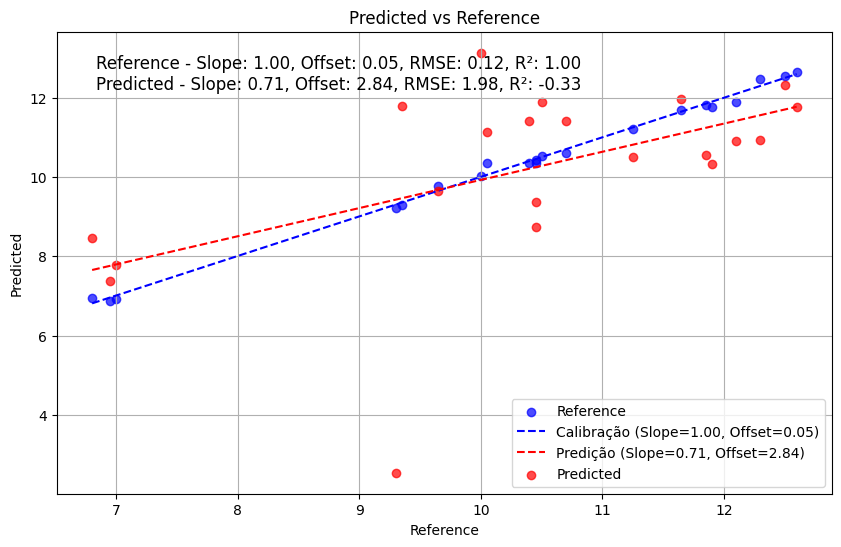

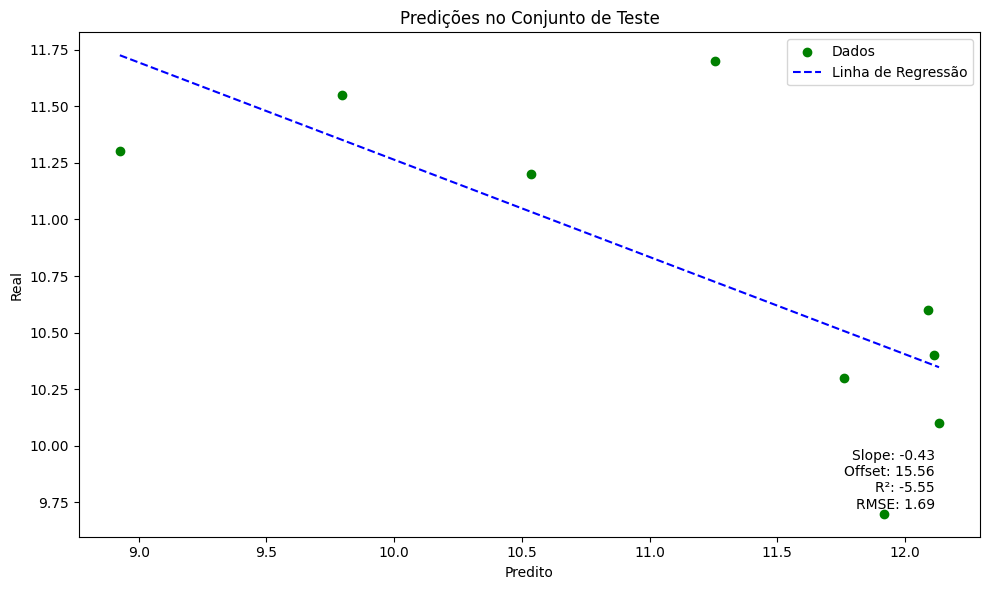

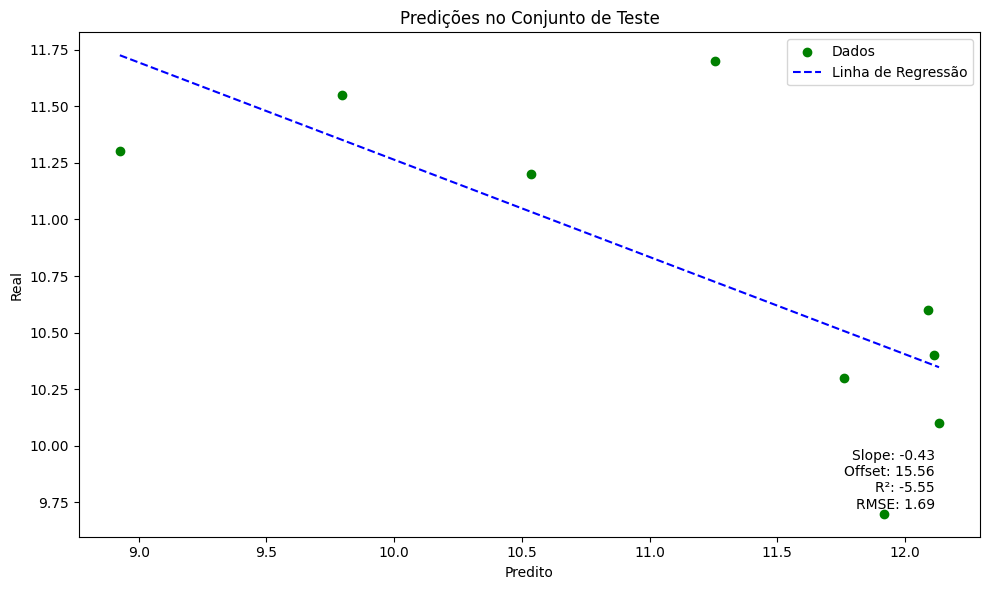

In [11]:
calibration_msc_sst, validation_msc_sst, Y_predict_msc_sst, plot_infos = build_model(df_msc_cal, df_msc_cal['BRIX'], df_msc_val, df_msc_val['BRIX'])

plot_infos_msc = add_plot_infos(plot_infos_msc, plot_infos, 'BRIX')

Número de componentes: 9


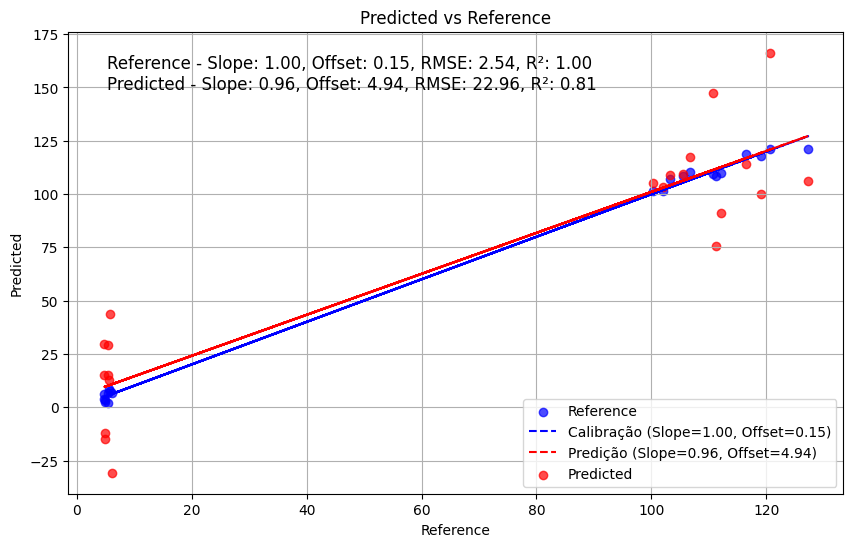

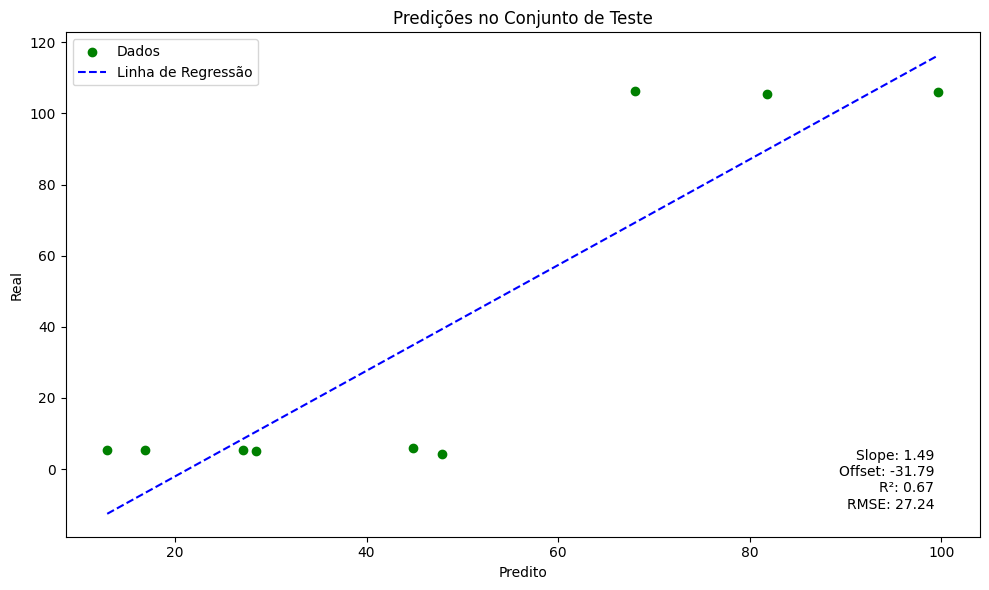

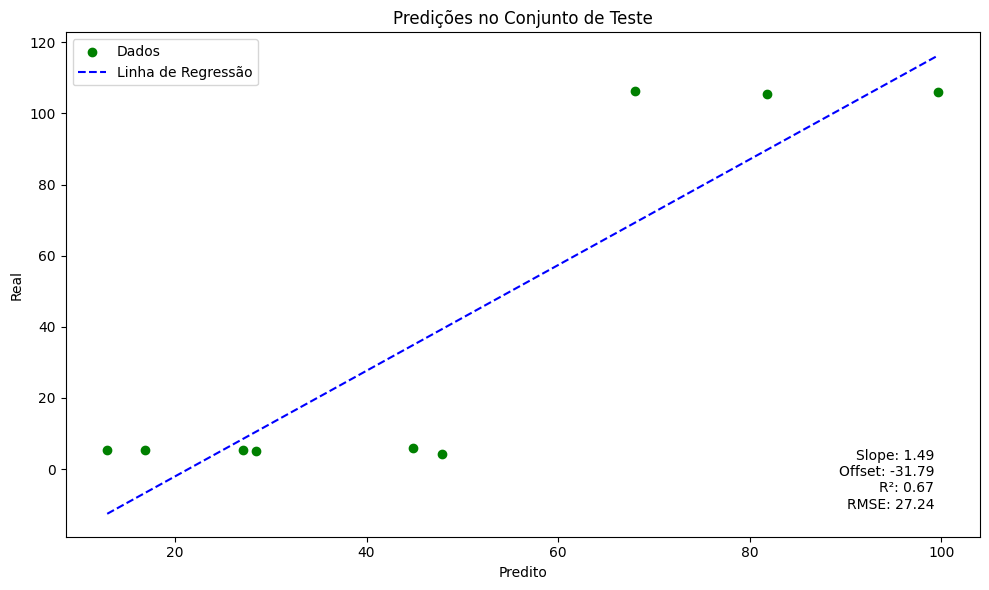

In [12]:
calibration_msc_firmeza, validation_msc_firmeza, Y_predict_msc_firmeza, plot_infos = build_model(df_msc_cal, df_msc_cal['FIRMNESS'], df_msc_val, df_msc_val['FIRMNESS'])

plot_infos_msc = add_plot_infos(plot_infos_msc, plot_infos, 'FIRMNESS')

Número de componentes: 9


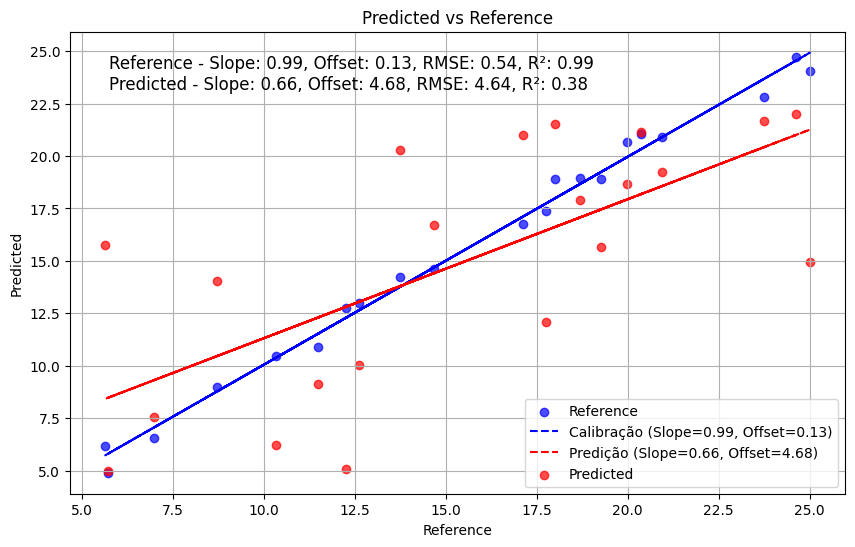

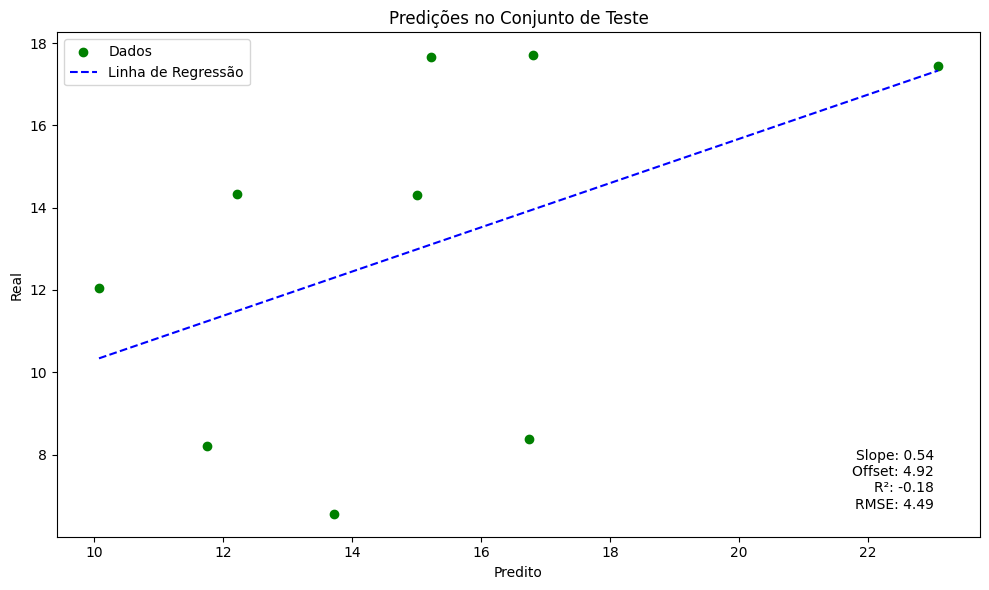

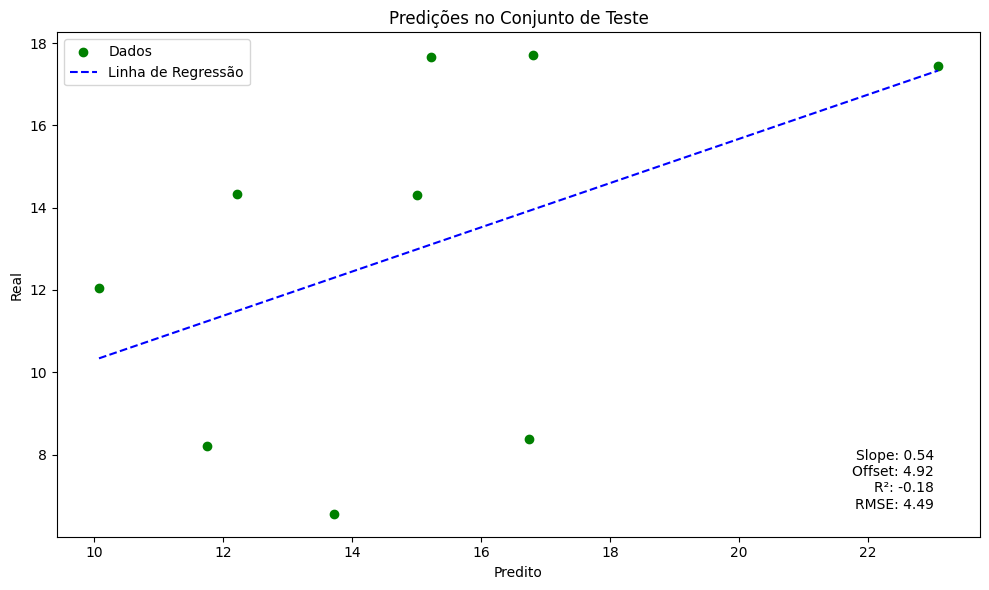

In [13]:
calibration_msc_aac, validation_msc_aac, Y_predict_msc_aac, plot_infos = build_model(df_msc_cal, df_msc_cal['% AAC'], df_msc_val, df_msc_val['% AAC'])

plot_infos_msc = add_plot_infos(plot_infos_msc, plot_infos, '% AAC')

Número de componentes: 8


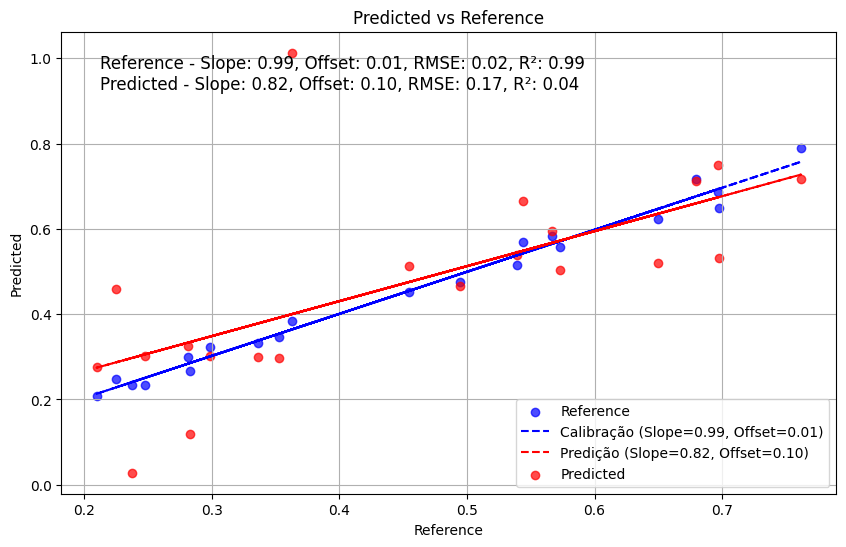

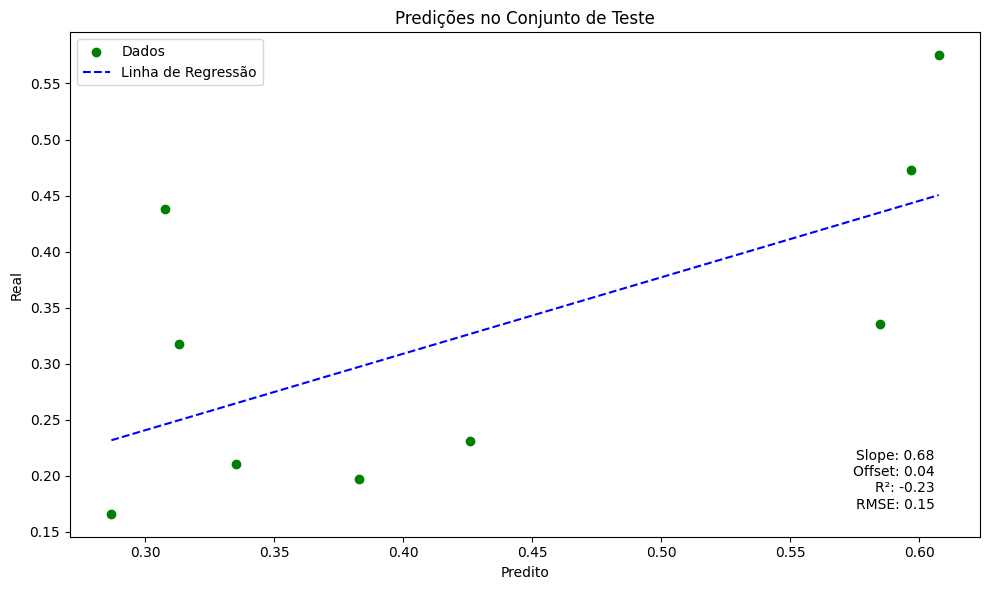

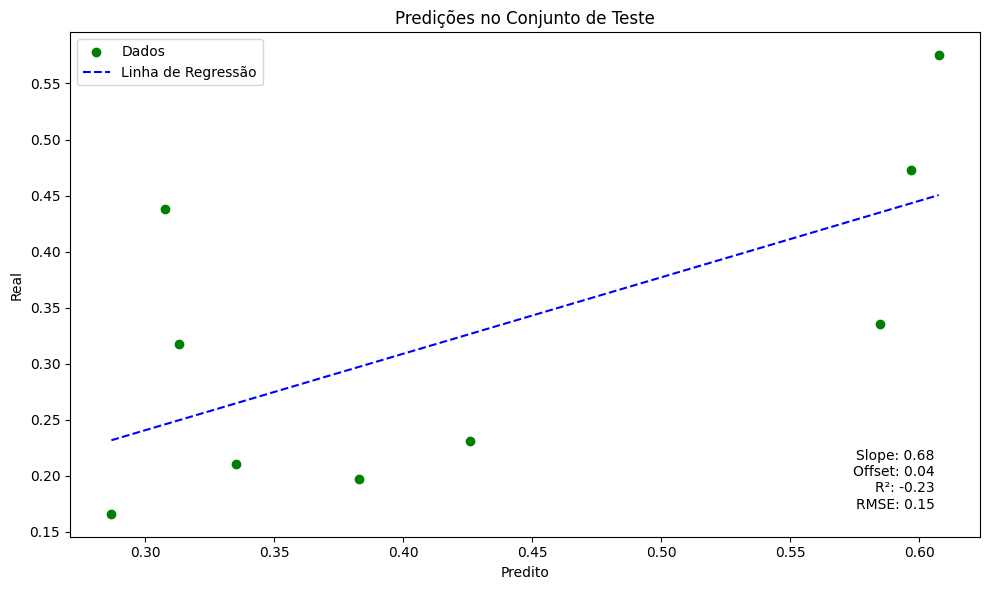

In [14]:
calibration_msc_att, validation_msc_att, Y_predict_msc_att, plot_infos = build_model(df_msc_cal, df_msc_cal['(ATT)'], df_msc_val, df_msc_val['(ATT)'])

plot_infos_msc = add_plot_infos(plot_infos_msc, plot_infos, '(ATT)')

Número de componentes: 5


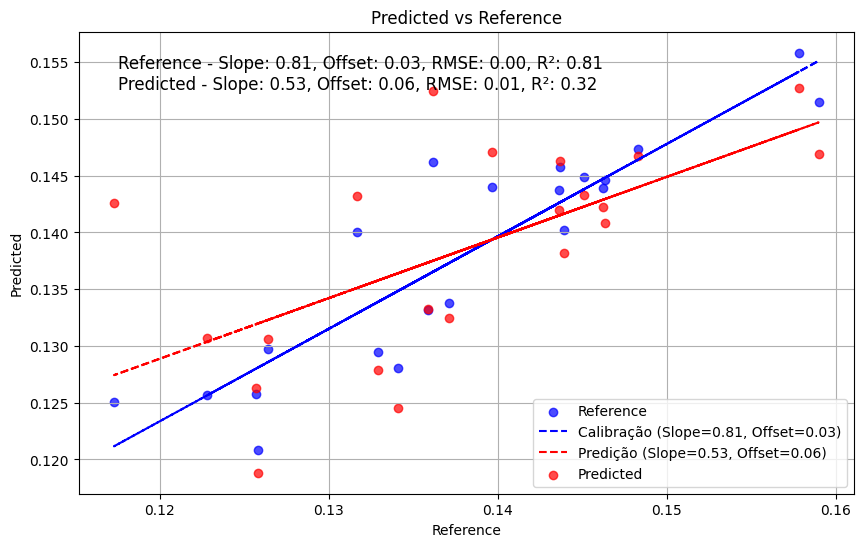

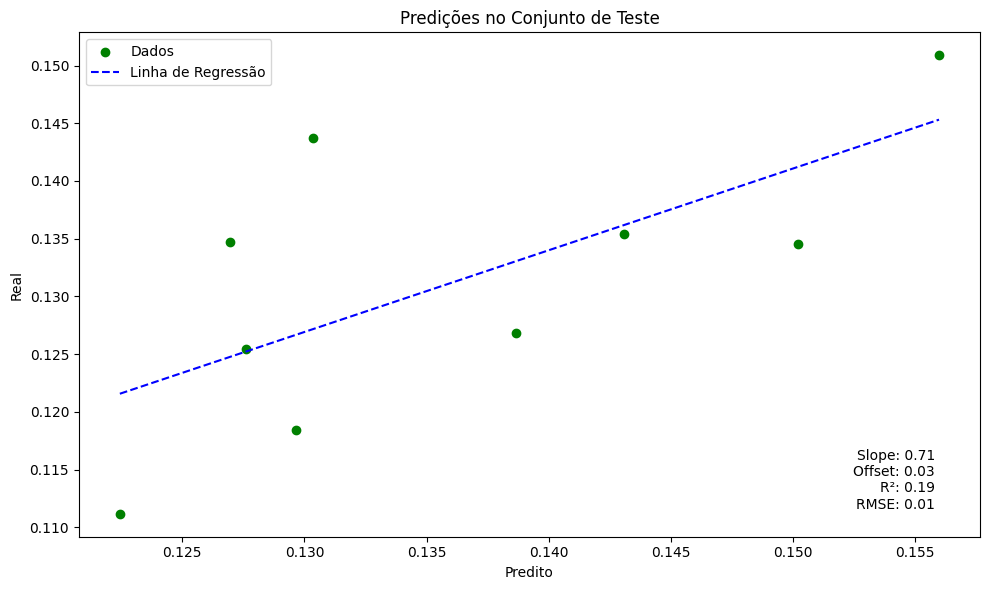

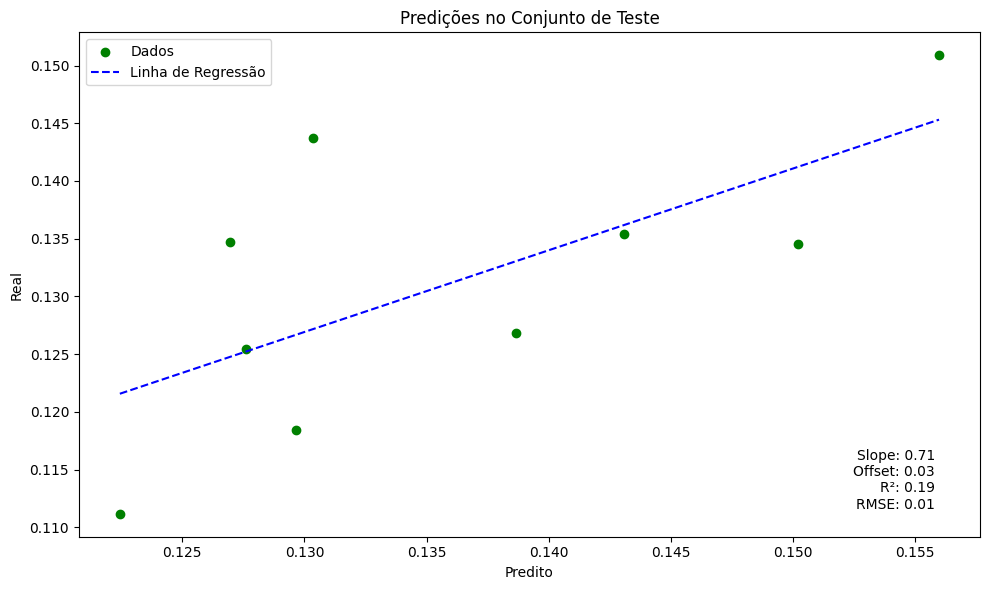

In [15]:
calibration_msc_ubs, validation_msc_ubs, Y_predict_msc_ubs, plot_infos = build_model(df_msc_cal, df_msc_cal['massa seca(%)'], df_msc_val, df_msc_val['massa seca(%)'])

plot_infos_msc = add_plot_infos(plot_infos_msc, plot_infos, 'massa seca(%)')

In [16]:
plot_infos_msc.to_excel('plot_infos_plsr_msc.xlsx', index=False)
plot_infos_msc

,Attribute,Y,R²,RMSE,Offset,Slope
0,BRIX,Referência,0.995354,0.117166,0.048173,0.995354
1,BRIX,Predição,-0.326131,1.979533,2.837567,0.708694
2,BRIX,Validação,-5.550451,1.688868,15.559572,-0.429597
3,FIRMNESS,Referência,0.997678,2.544125,0.152989,0.997678
4,FIRMNESS,Predição,0.810933,22.956470,4.943488,0.960707
5,FIRMNESS,Validação,0.670707,27.239106,-31.794034,1.486116
6,% AAC,Referência,0.991451,0.544740,0.133417,0.991451
7,% AAC,Predição,0.380968,4.635303,4.682805,0.662821
8,% AAC,Validação,-0.177001,4.486716,4.920920,0.537485
9,(ATT),Referência,0.985196,0.021618,0.006691,0.985196


Número de componentes: 9


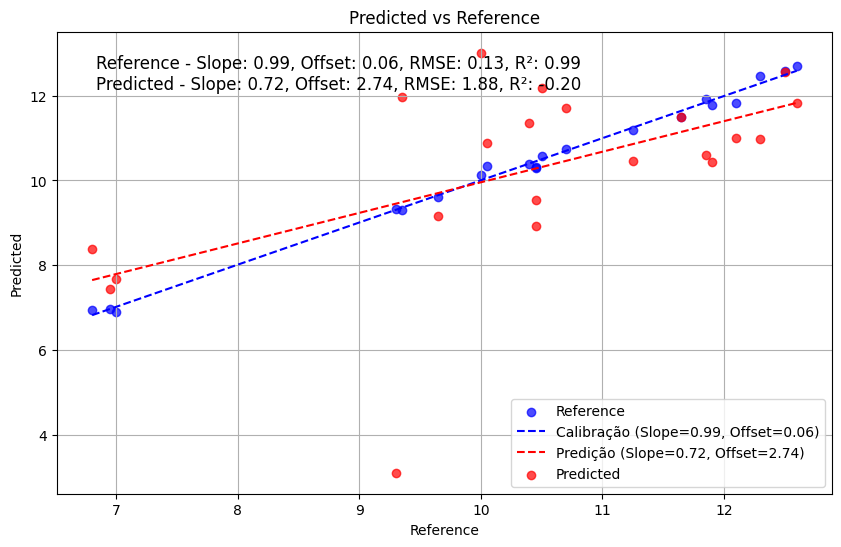

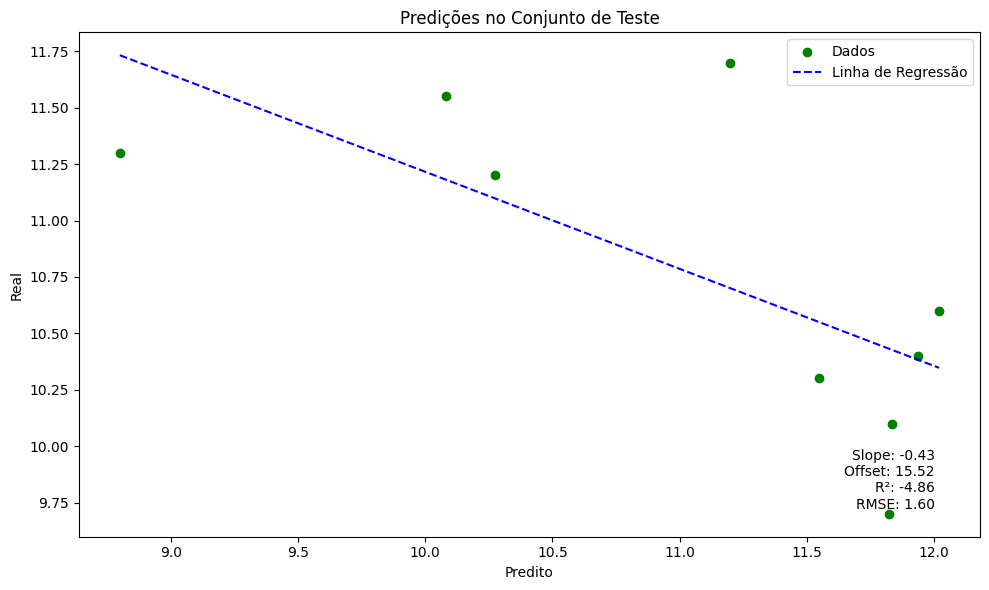

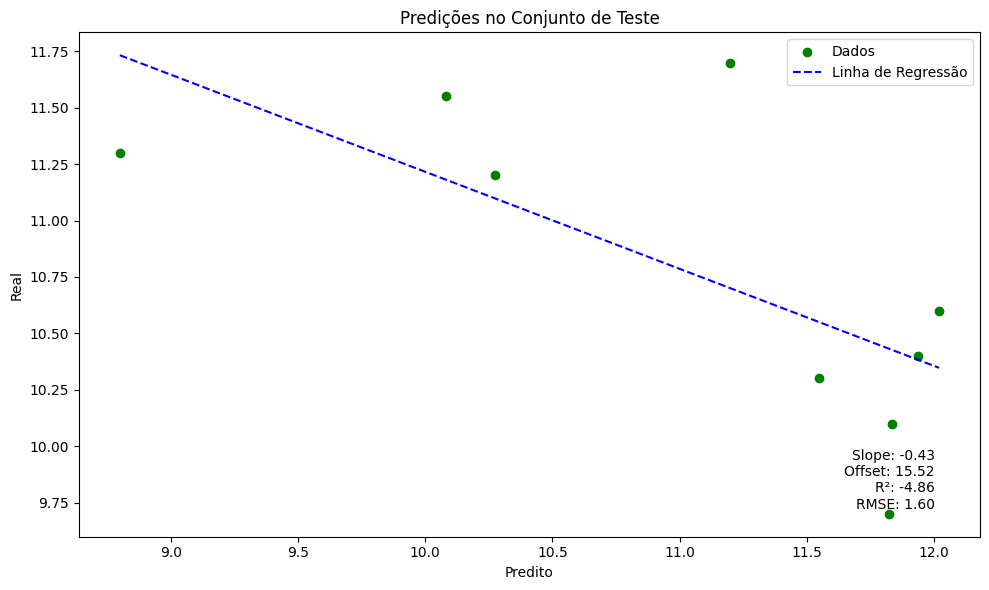

In [17]:
calibration_snv_sst, validation_snv_sst, Y_predict_snv_sst, plot_infos = build_model(df_snv_cal, df_snv_cal['BRIX'], df_snv_val, df_snv_val['BRIX'])

plot_infos_snv = add_plot_infos(plot_infos_snv, plot_infos, 'BRIX')

Número de componentes: 9


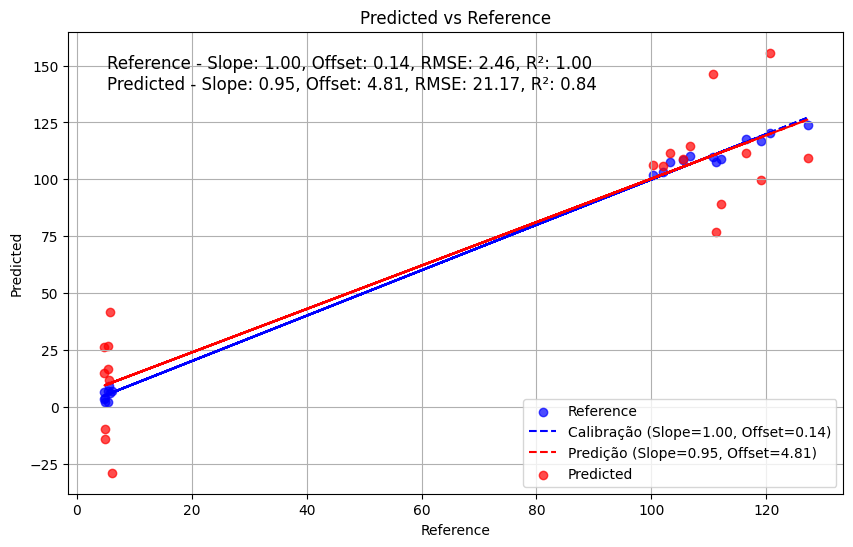

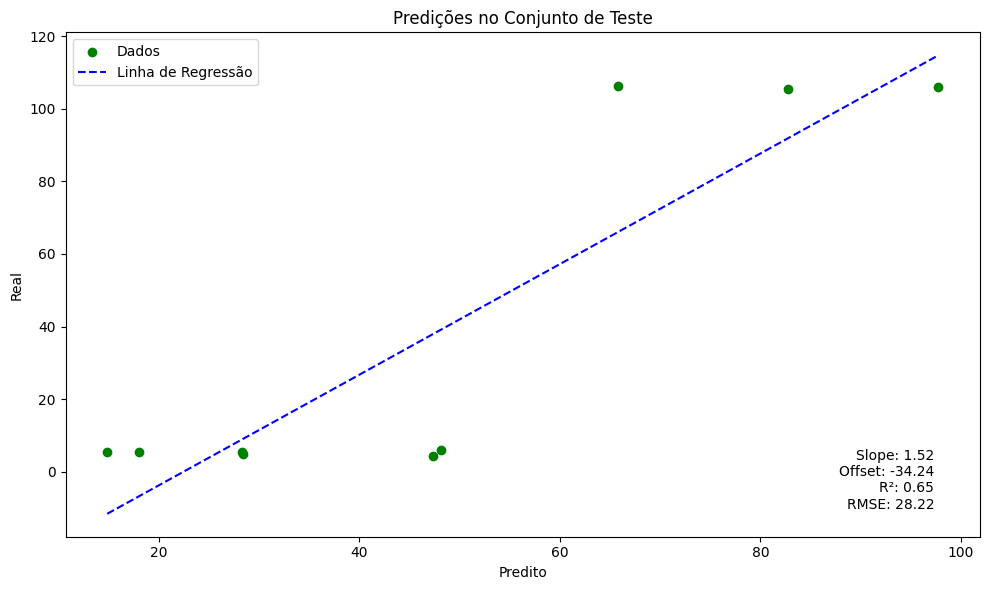

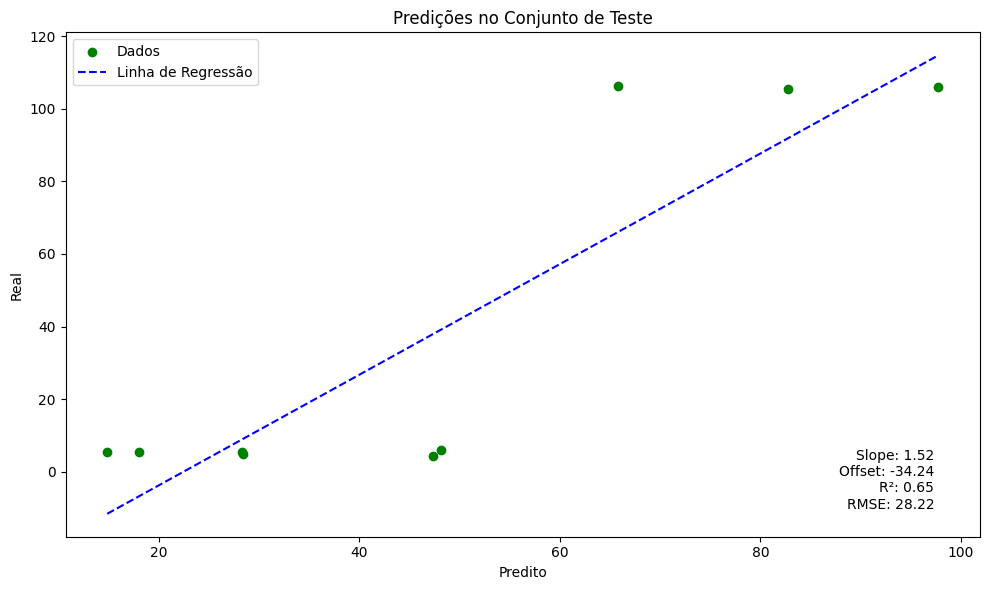

In [18]:
calibration_snv_firmeza, validation_snv_firmeza, Y_predict_snv_firmeza, plot_infos = build_model(df_snv_cal, df_snv_cal['FIRMNESS'], df_snv_val, df_snv_val['FIRMNESS'])

plot_infos_snv = add_plot_infos(plot_infos_snv, plot_infos, 'FIRMNESS')

Número de componentes: 9


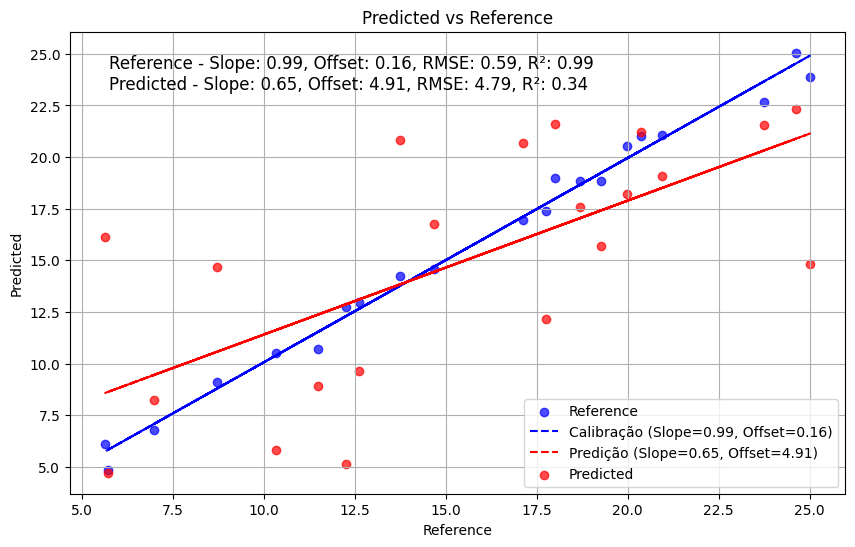

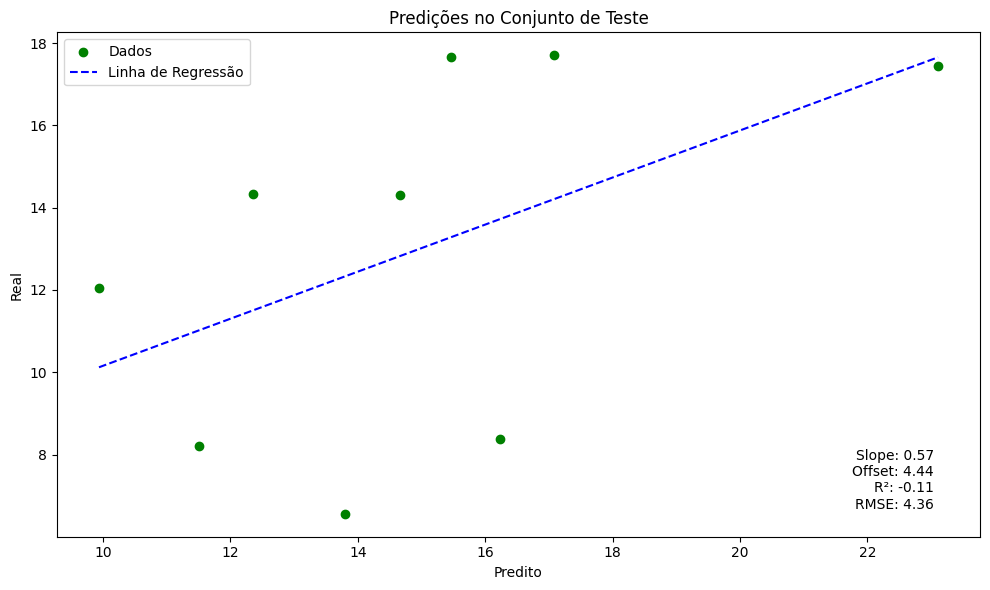

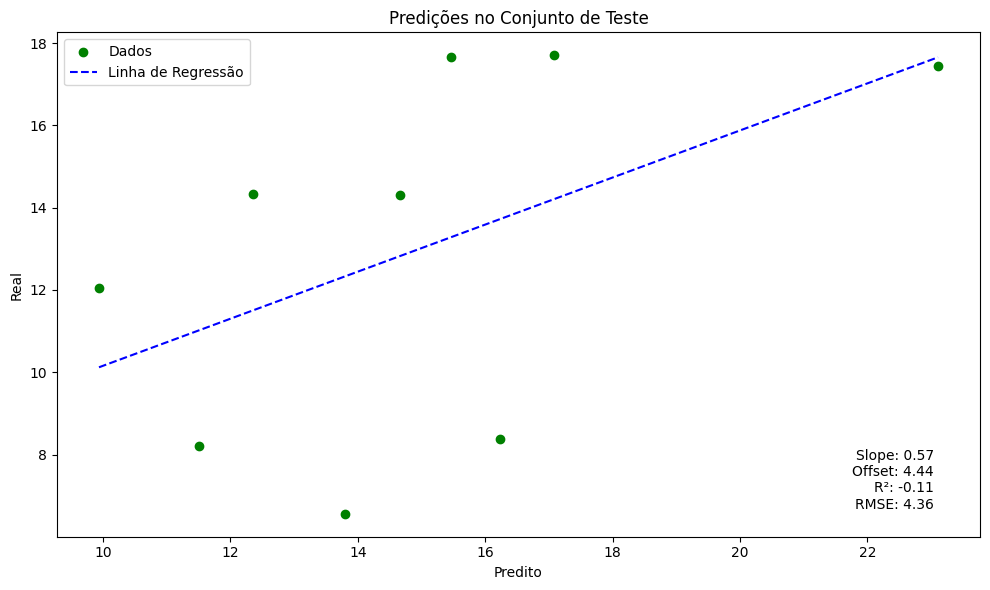

In [19]:
calibration_snv_aac, validation_snv_aac, Y_predict_snv_aac, plot_infos = build_model(df_snv_cal, df_snv_cal['% AAC'], df_snv_val, df_snv_val['% AAC'])

plot_infos_snv = add_plot_infos(plot_infos_snv, plot_infos, '% AAC')

Número de componentes: 9


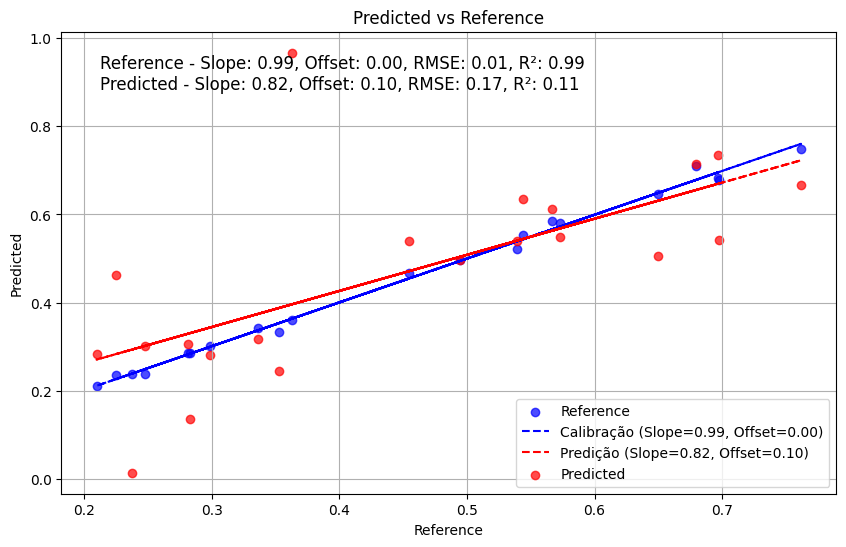

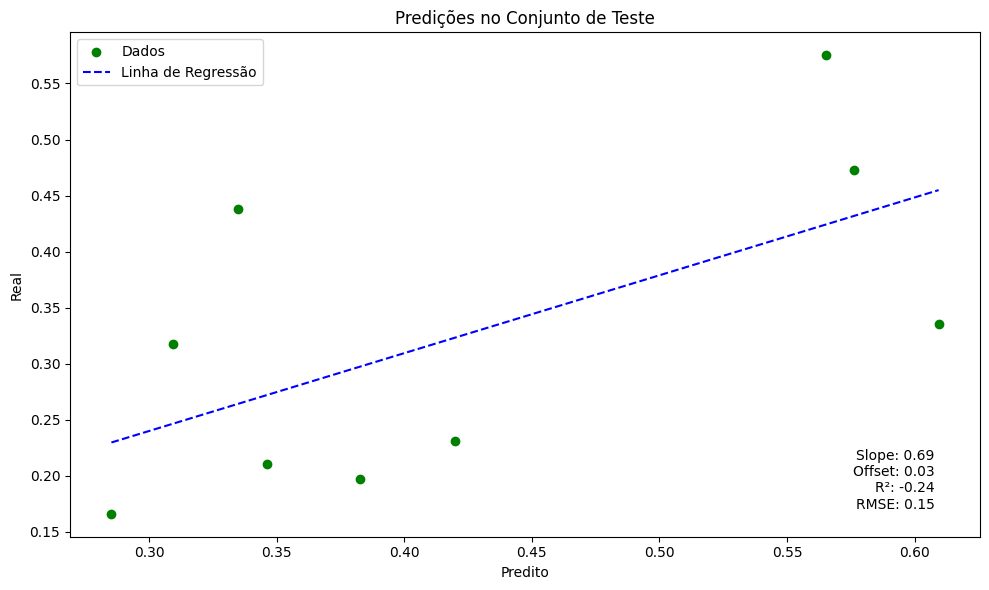

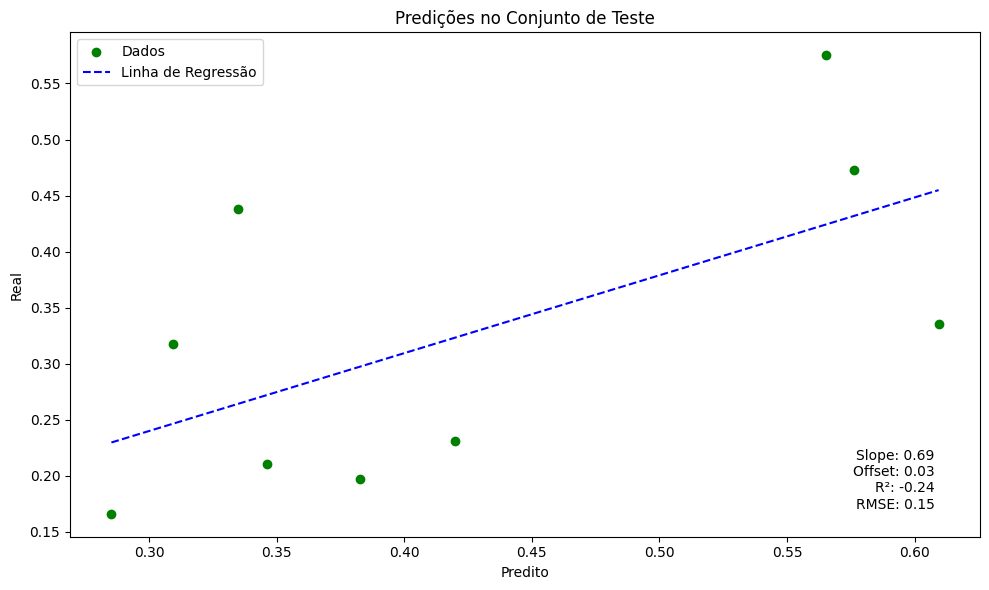

In [20]:
calibration_snv_aac, validation_snv_att, Y_predict_snv_att, plot_infos = build_model(df_snv_cal, df_snv_cal['(ATT)'], df_snv_val, df_snv_val['(ATT)'])

plot_infos_snv = add_plot_infos(plot_infos_snv, plot_infos, '(ATT)')

Número de componentes: 5


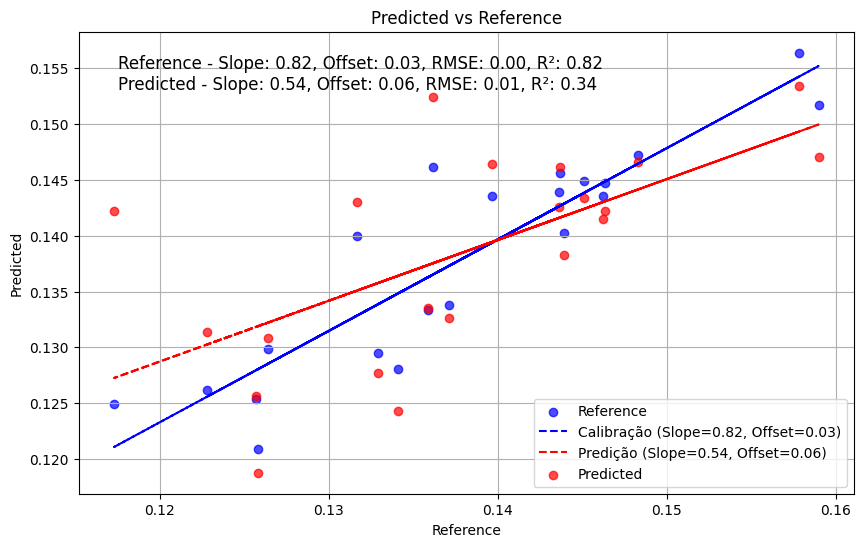

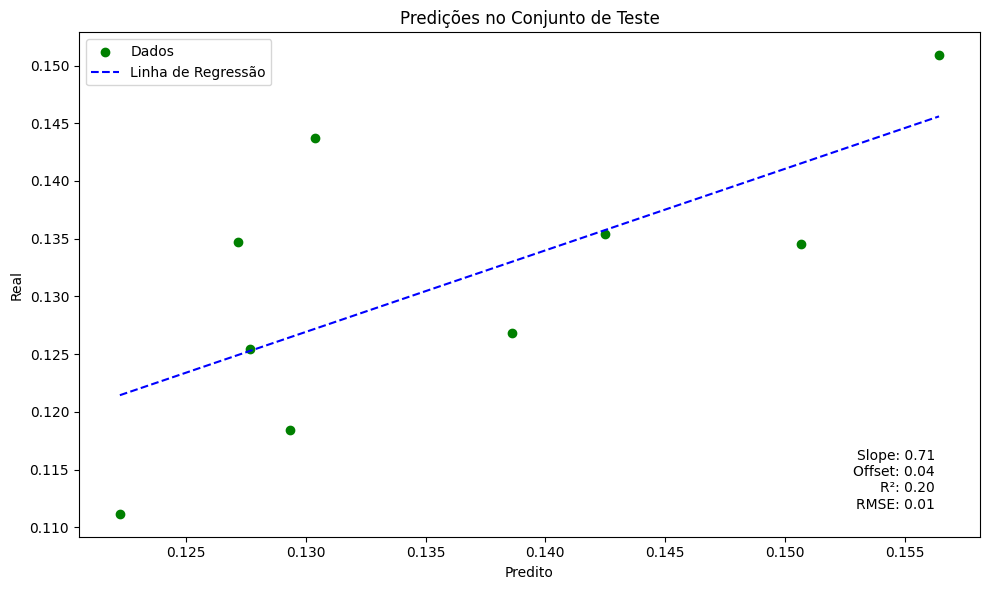

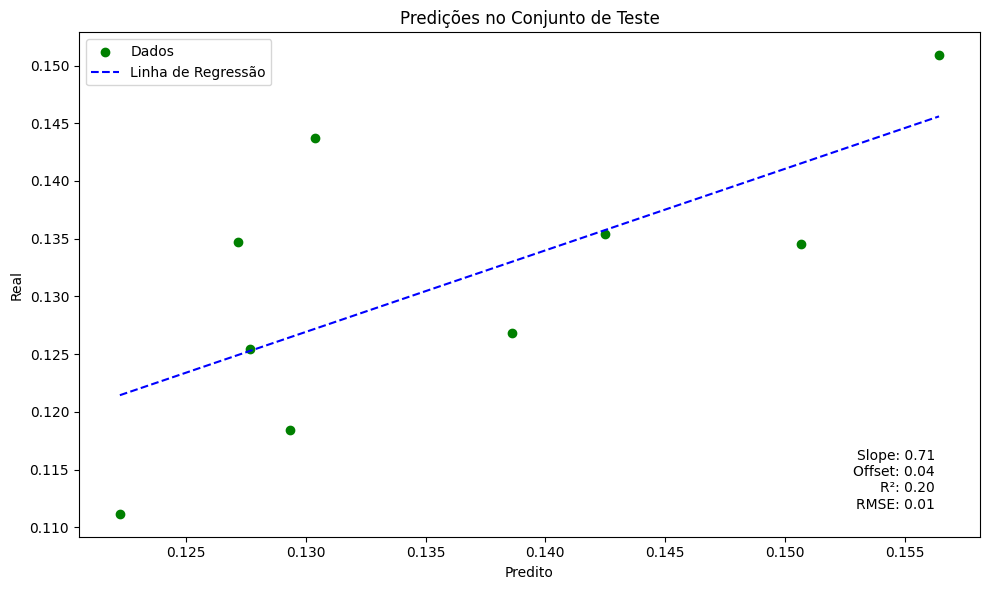

In [21]:
calibration_snv_ubs, validation_snv_ubs, Y_predict_snv_ubs, plot_infos = build_model(df_snv_cal, df_snv_cal['massa seca(%)'], df_snv_val, df_snv_val['massa seca(%)'])

plot_infos_snv = add_plot_infos(plot_infos_snv, plot_infos, 'massa seca(%)')

In [22]:
plot_infos_snv.to_excel('plot_infos_plsr_snv.xlsx', index=False)
plot_infos_snv

,Attribute,Y,R²,RMSE,Offset,Slope
0,BRIX,Referência,0.994291,0.129883,0.059198,0.994291
1,BRIX,Predição,-0.197089,1.880757,2.744929,0.721077
2,BRIX,Validação,-4.860448,1.597444,15.517511,-0.430146
3,FIRMNESS,Referência,0.997835,2.456531,0.142636,0.997835
4,FIRMNESS,Predição,0.839221,21.169593,4.811089,0.954455
5,FIRMNESS,Validação,0.646453,28.224431,-34.244427,1.523909
6,% AAC,Referência,0.989978,0.589792,0.156397,0.989978
7,% AAC,Predição,0.340257,4.785299,4.912654,0.648867
8,% AAC,Validação,-0.110366,4.357860,4.436584,0.571965
9,(ATT),Referência,0.994815,0.012794,0.002344,0.994815


Número de componentes: 7


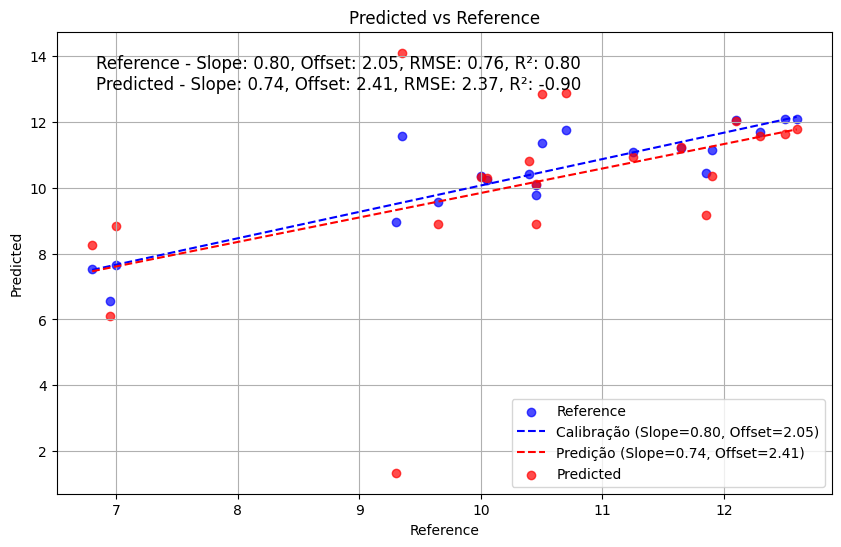

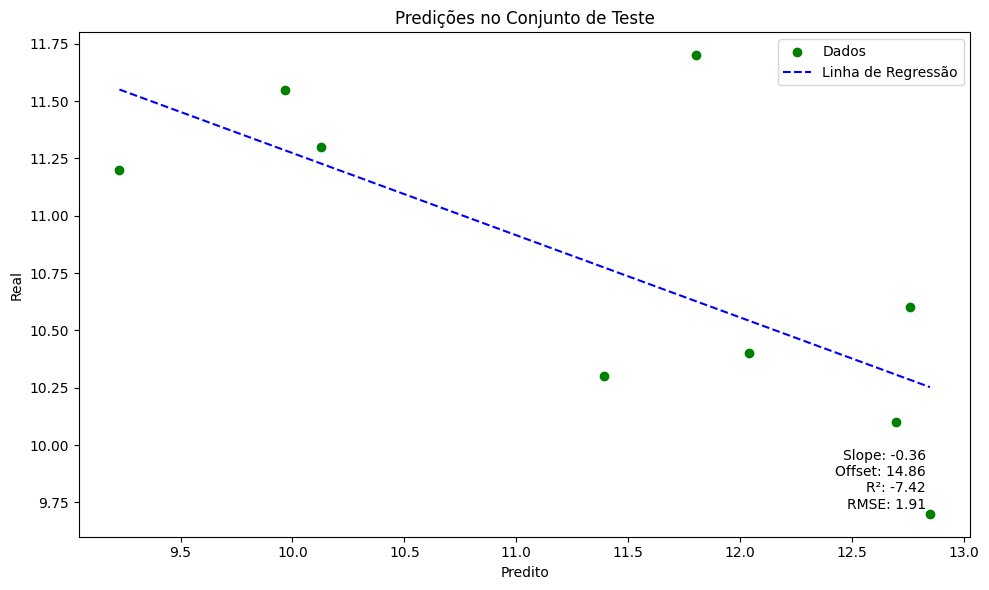

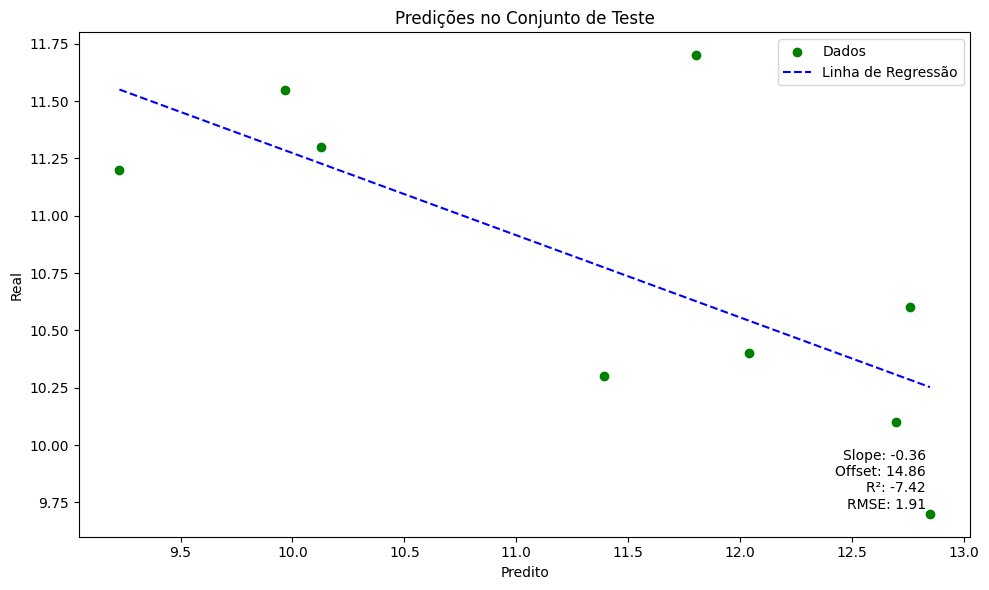

In [23]:
calibration_sg_sst, validation_sg_sst, Y_predict_sg_sst, plot_infos = build_model(df_sg_cal, df_sg_cal['BRIX'], df_sg_val, df_sg_val['BRIX'])

plot_infos_sg = add_plot_infos(plot_infos_sg, plot_infos, 'BRIX')

Número de componentes: 9


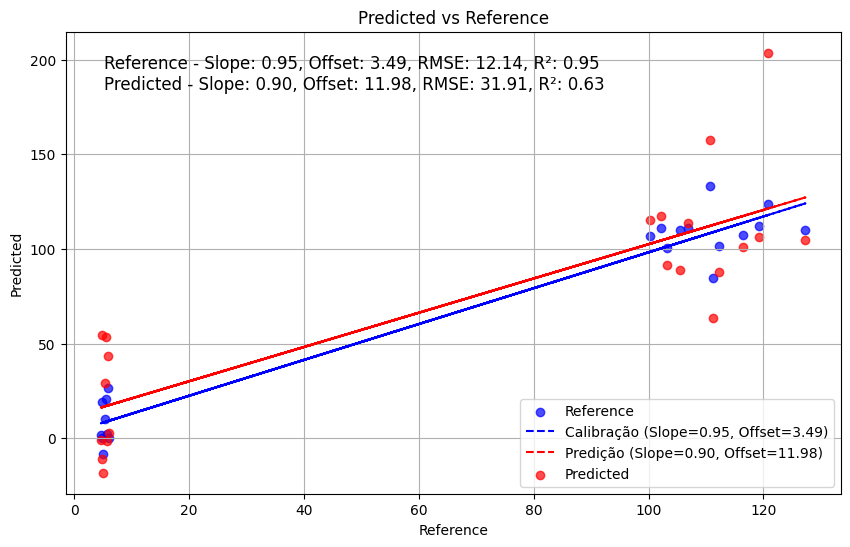

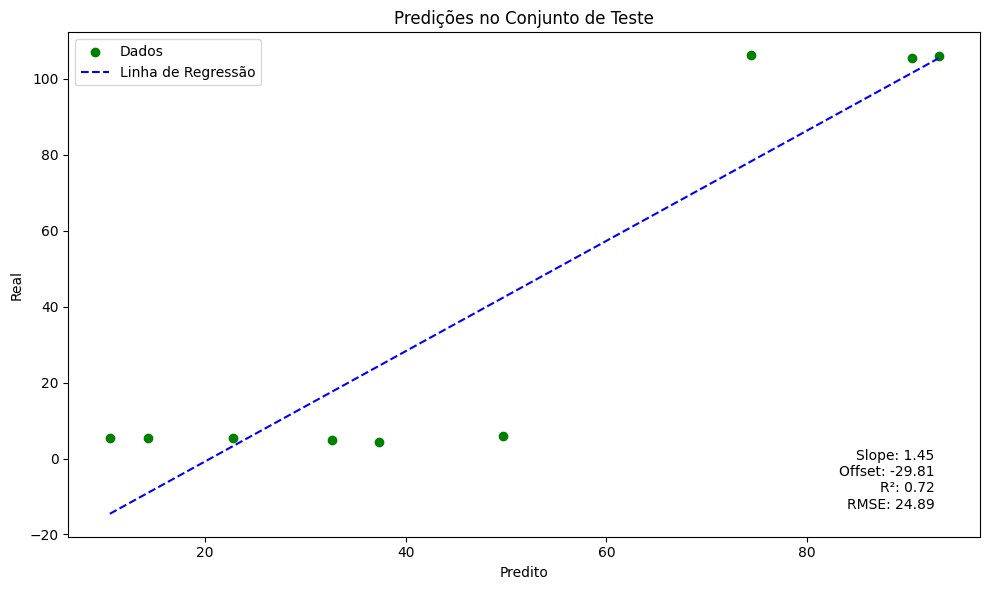

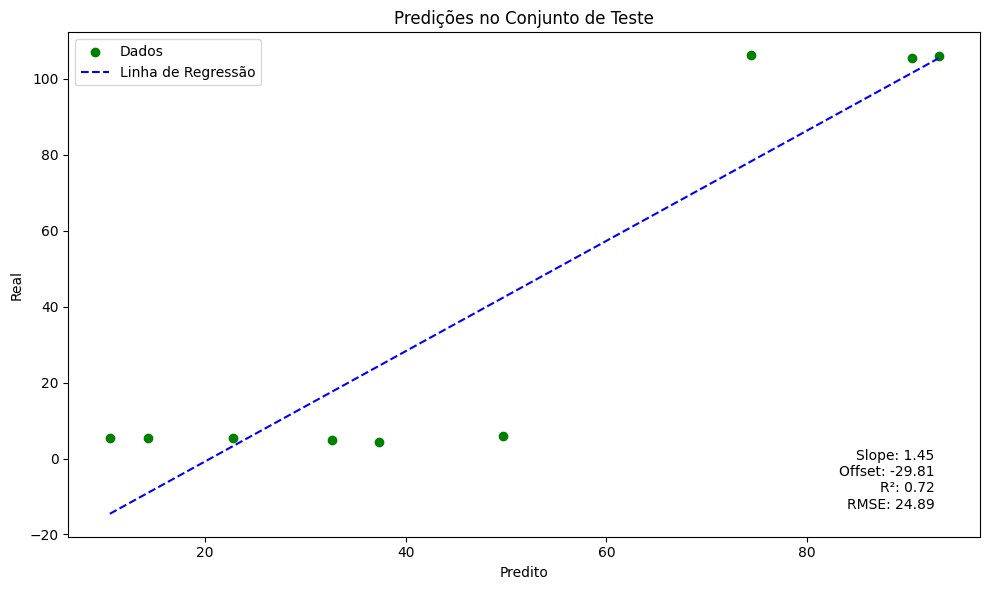

In [24]:
calibration_sg_firmeza, validation_sg_firmeza, Y_predict_sg_firmeza, plot_infos = build_model(df_sg_cal, df_sg_cal['FIRMNESS'], df_sg_val, df_sg_val['FIRMNESS'])

plot_infos_sg = add_plot_infos(plot_infos_sg, plot_infos, 'FIRMNESS')

Número de componentes: 9


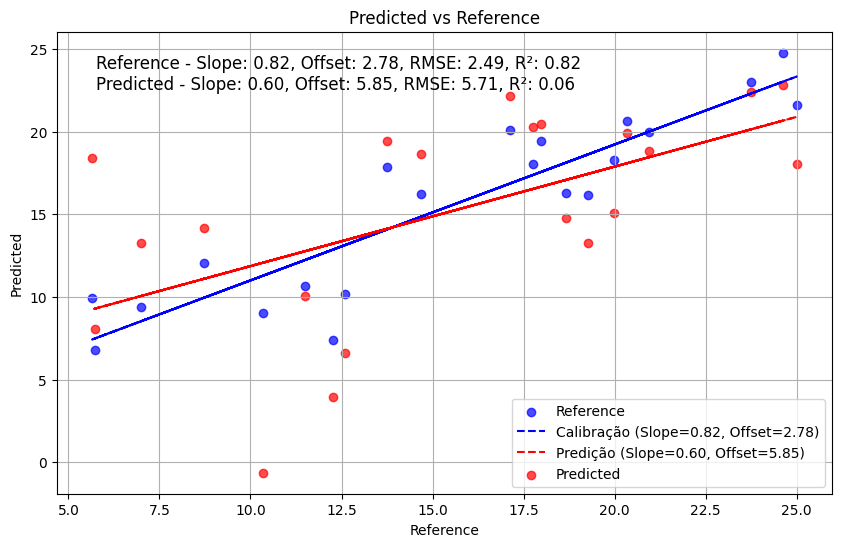

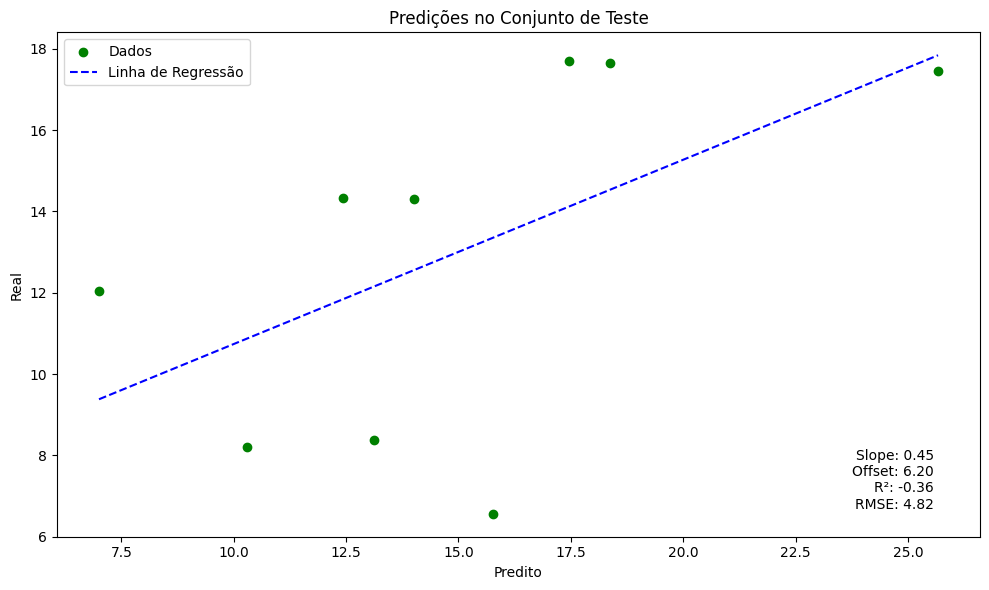

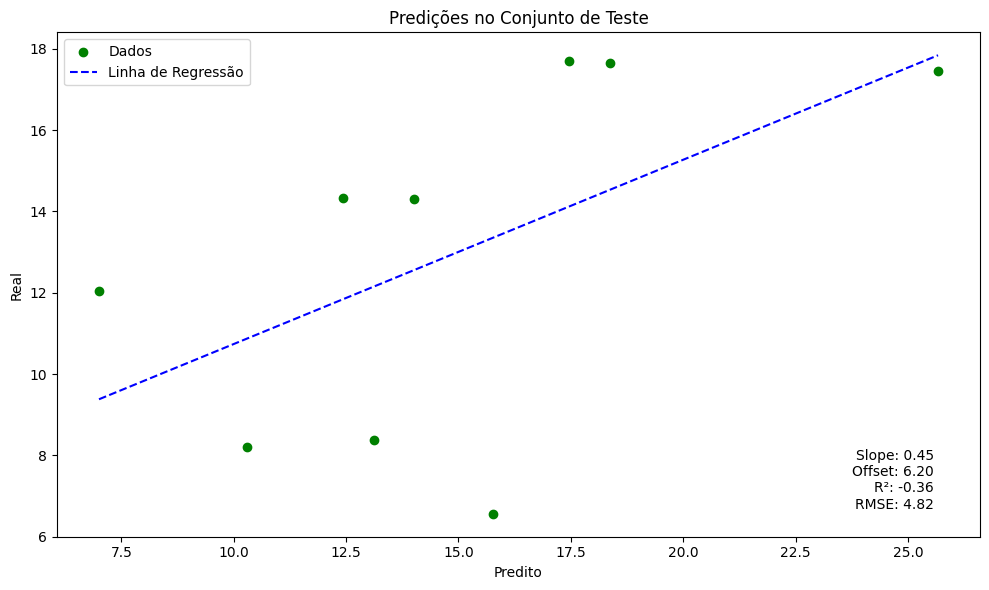

In [25]:
calibration_sg_aac, validation_sg_aac, Y_predict_sg_aac, plot_infos = build_model(df_sg_cal, df_sg_cal['% AAC'], df_sg_val, df_sg_val['% AAC'])

plot_infos_sg = add_plot_infos(plot_infos_sg, plot_infos, '% AAC')

Número de componentes: 9


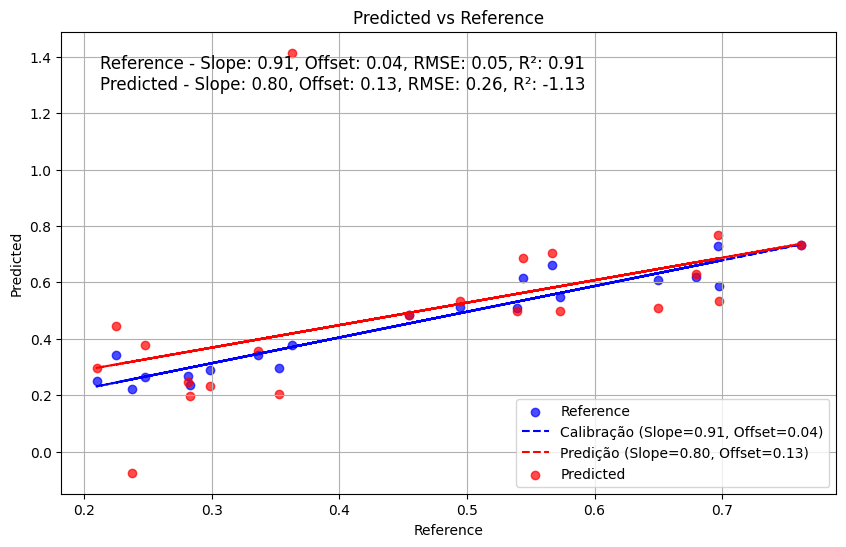

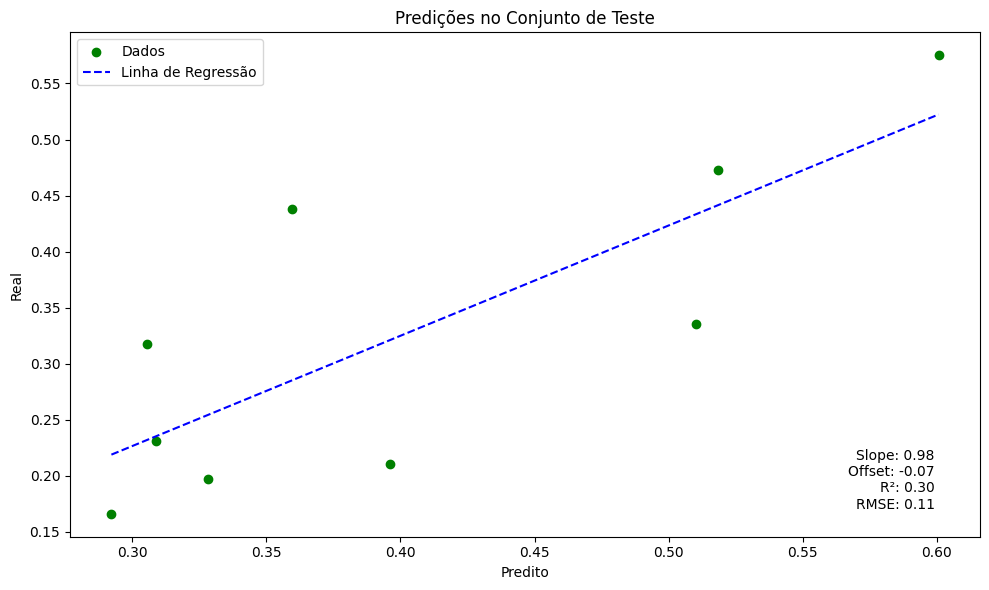

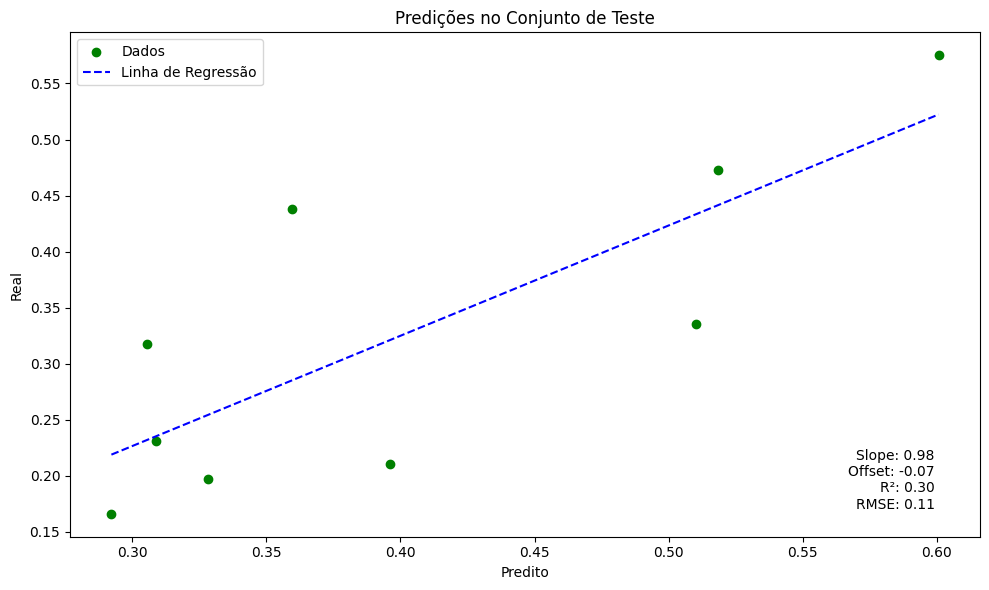

In [26]:
calibration_sg_att, validation_sg_att, Y_predict_sg_att, plot_infos = build_model(df_sg_cal, df_sg_cal['(ATT)'], df_sg_val, df_sg_val['(ATT)'])

plot_infos_sg = add_plot_infos(plot_infos_sg, plot_infos, '(ATT)')

Número de componentes: 8


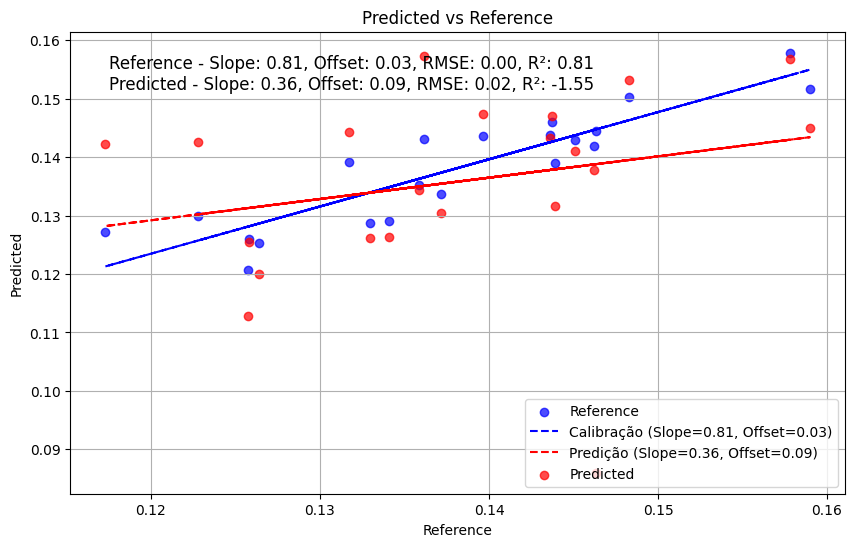

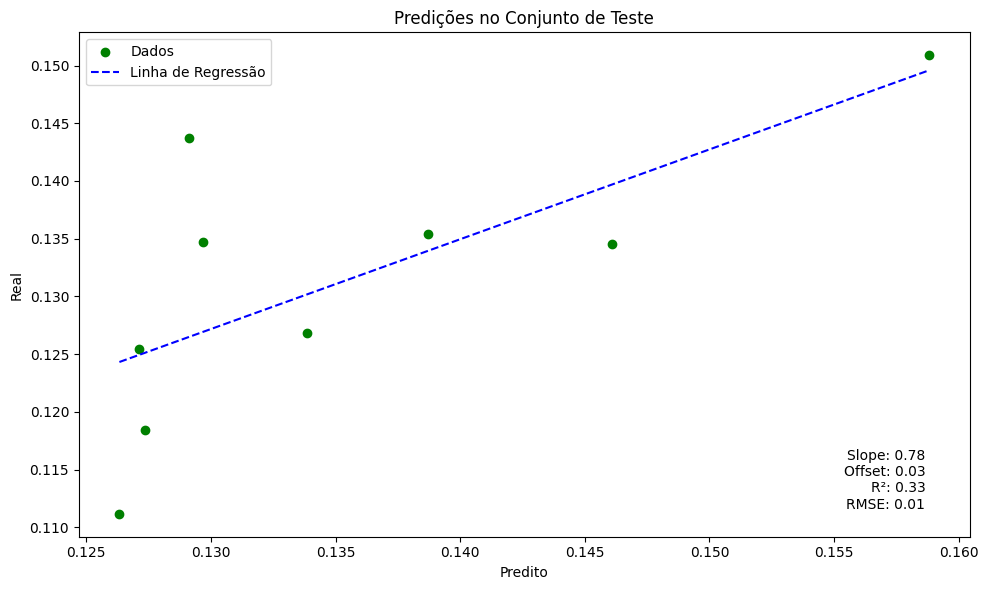

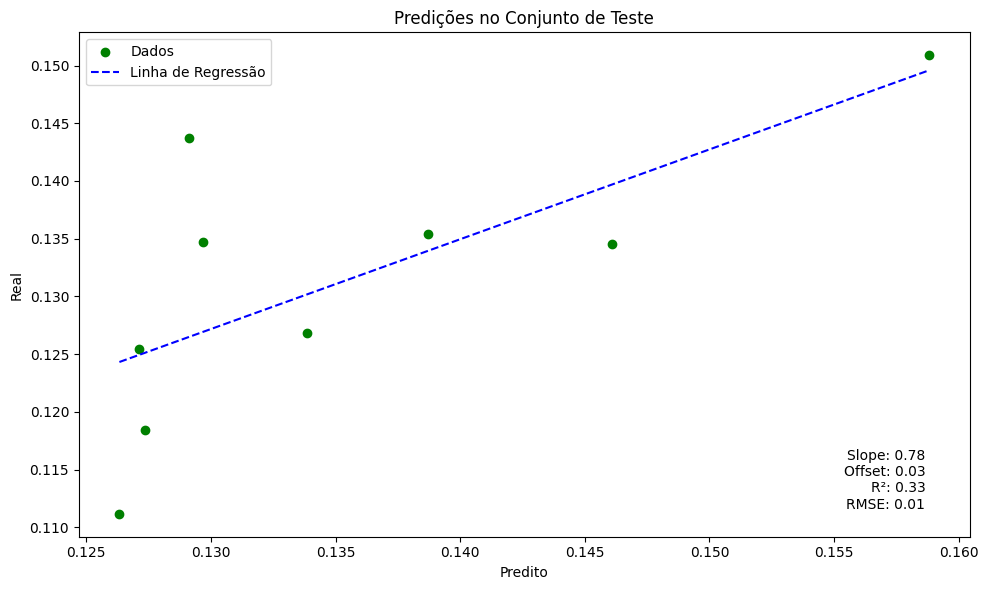

In [27]:
calibration_sg_ubs, validation_sg_ubs, Y_predict_sg_ubs, plot_infos = build_model(df_sg_cal, df_sg_cal['massa seca(%)'], df_sg_val, df_sg_val['massa seca(%)'])

plot_infos_sg = add_plot_infos(plot_infos_sg, plot_infos, 'massa seca(%)')

In [28]:
plot_infos_sg.to_excel('plot_infos_plsr_sg.xlsx', index=False)
plot_infos_sg

,Attribute,Y,R²,RMSE,Offset,Slope
0,BRIX,Referência,0.802257,0.764399,2.050408,0.802257
1,BRIX,Predição,-0.898764,2.368673,2.405265,0.743947
2,BRIX,Validação,-7.421413,1.914929,14.856938,-0.358355
3,FIRMNESS,Referência,0.947087,12.144432,3.486089,0.947087
4,FIRMNESS,Predição,0.634591,31.914423,11.984352,0.904999
5,FIRMNESS,Validação,0.724990,24.892959,-29.813223,1.452530
6,% AAC,Referência,0.821647,2.488065,2.783260,0.821647
7,% AAC,Predição,0.059058,5.714826,5.847845,0.601494
8,% AAC,Validação,-0.358834,4.820847,6.202848,0.453496
9,(ATT),Referência,0.912347,0.052603,0.039620,0.912347


Número de componentes: 9


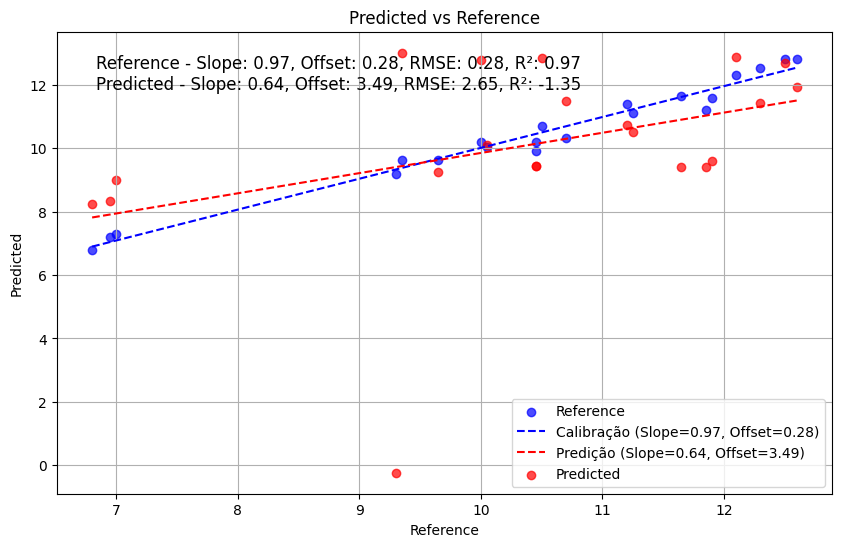

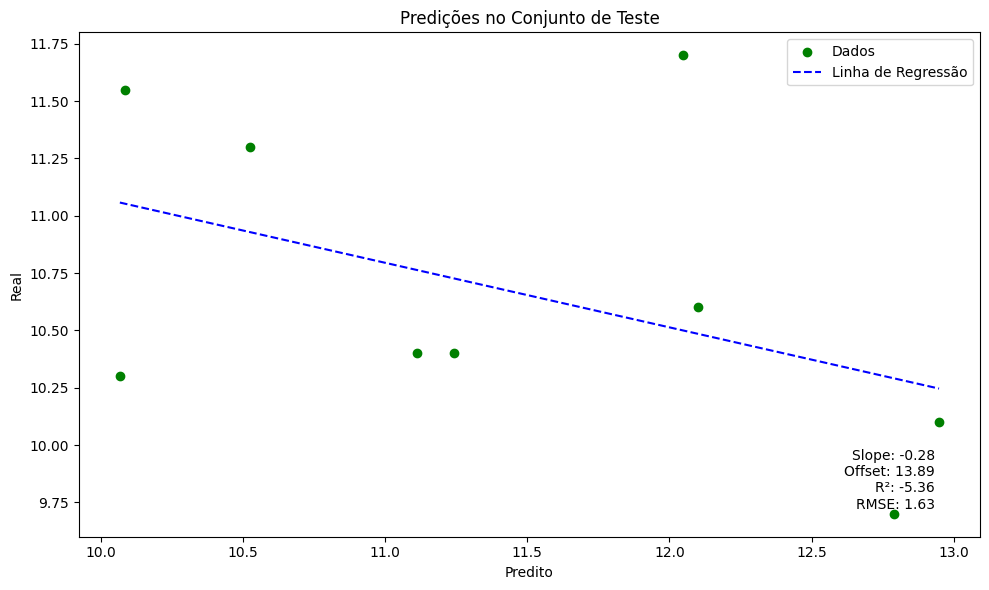

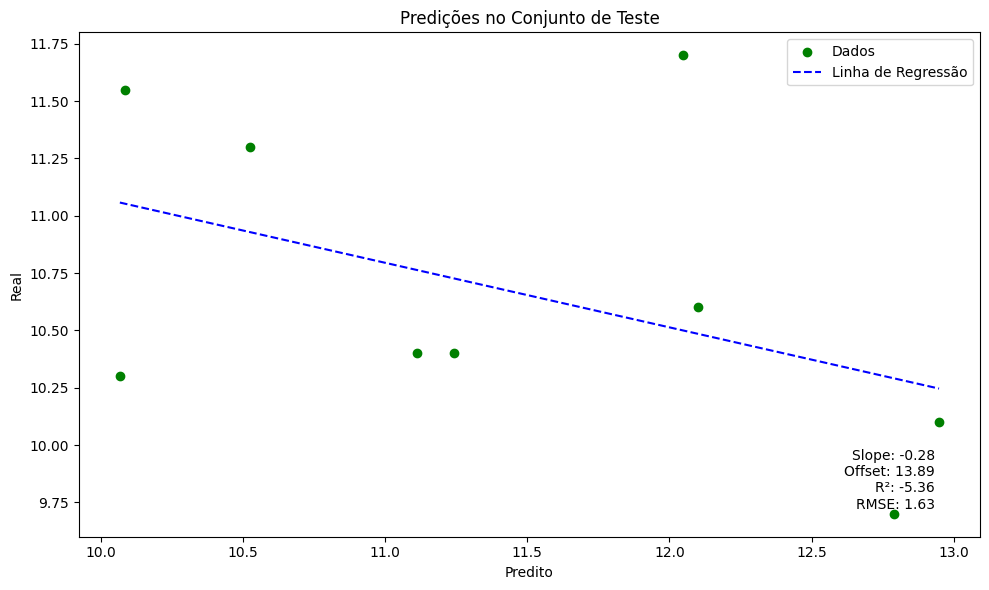

In [29]:
calibration_raw_sst, validation_raw_sst, Y_predict_raw_sst, plot_infos = build_model(df_raw_cal, df_raw_cal['BRIX'], df_raw_val, df_raw_val['BRIX'])

plot_infos_raw = add_plot_infos(plot_infos_raw, plot_infos, 'BRIX')

Número de componentes: 8


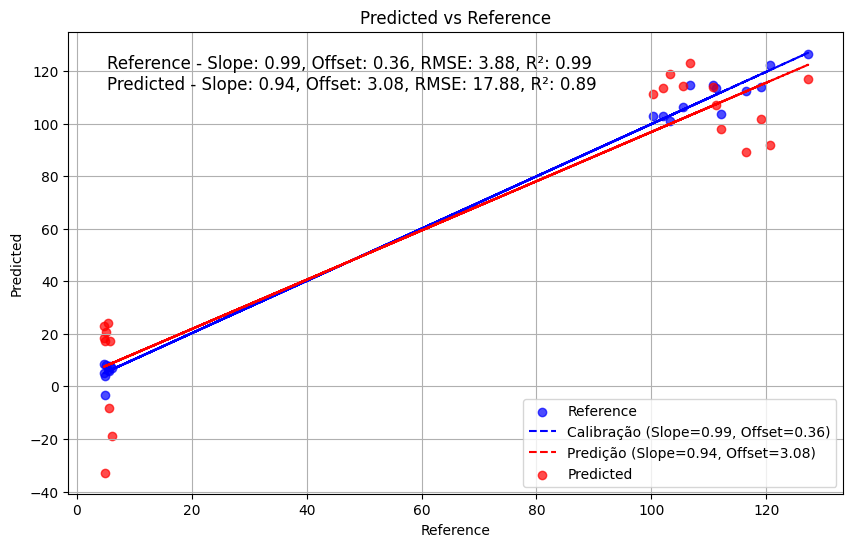

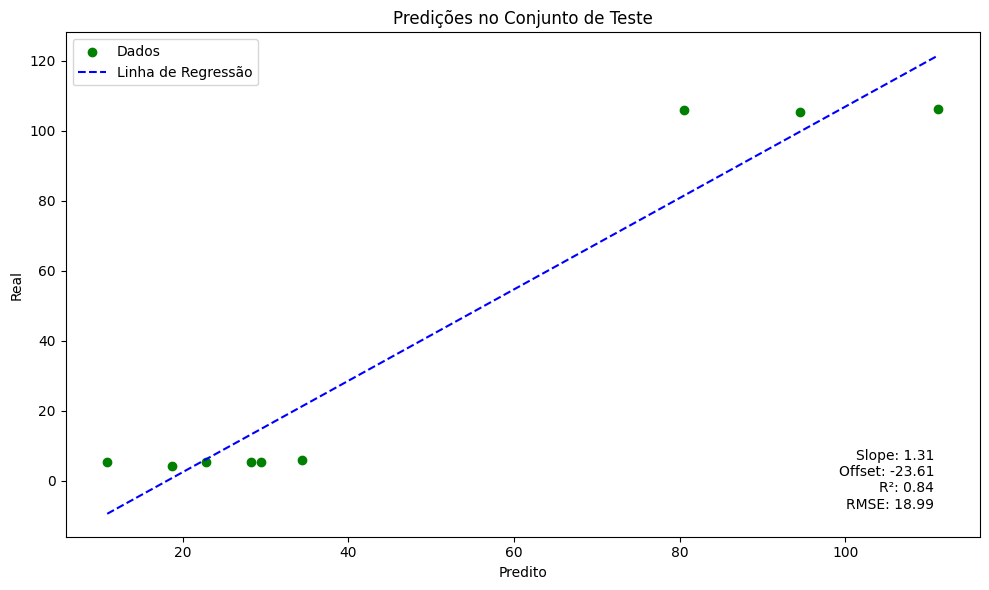

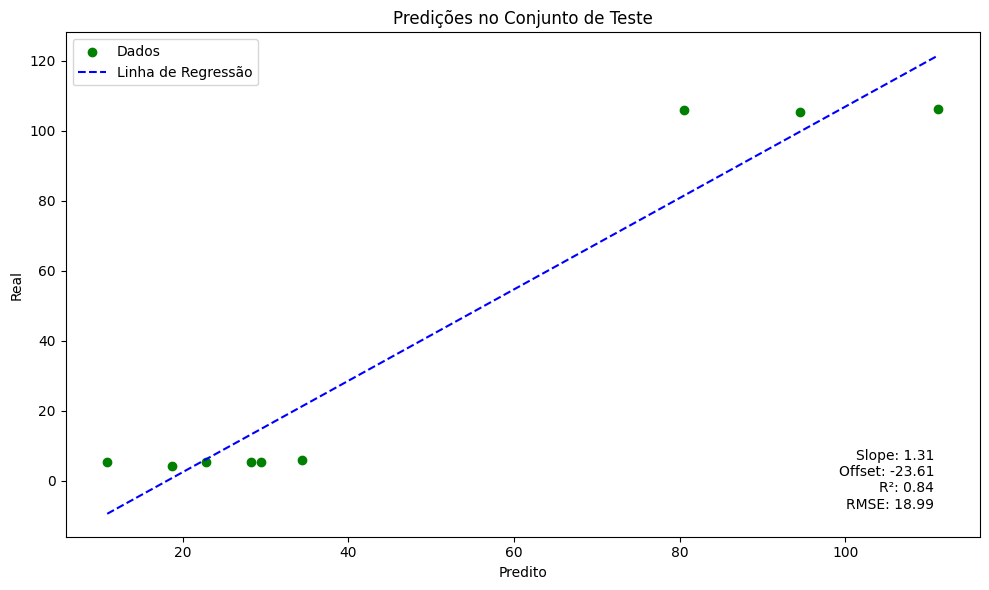

In [30]:
calibration_raw_firmeza, validation_raw_firmeza, Y_predict_raw_firmeza, plot_infos = build_model(df_raw_cal, df_raw_cal['FIRMNESS'], df_raw_val, df_raw_val['FIRMNESS'])

plot_infos_raw = add_plot_infos(plot_infos_raw, plot_infos, 'FIRMNESS')

Número de componentes: 9


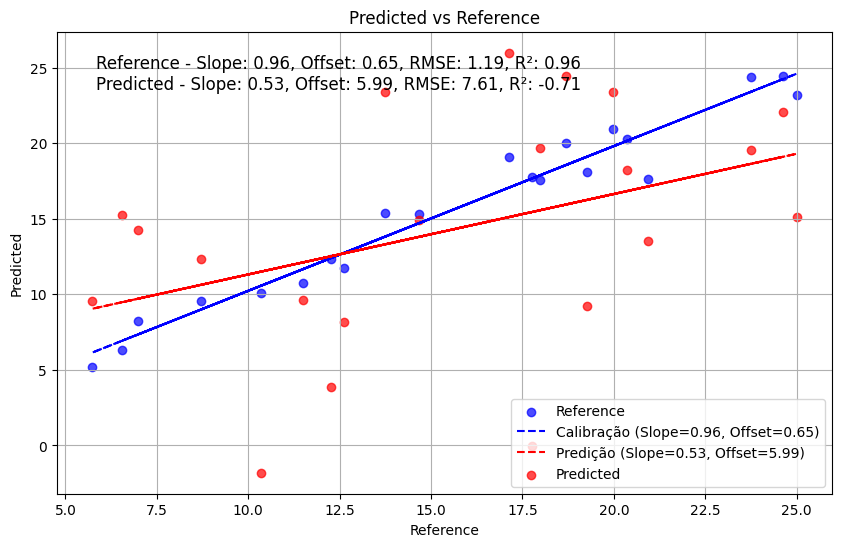

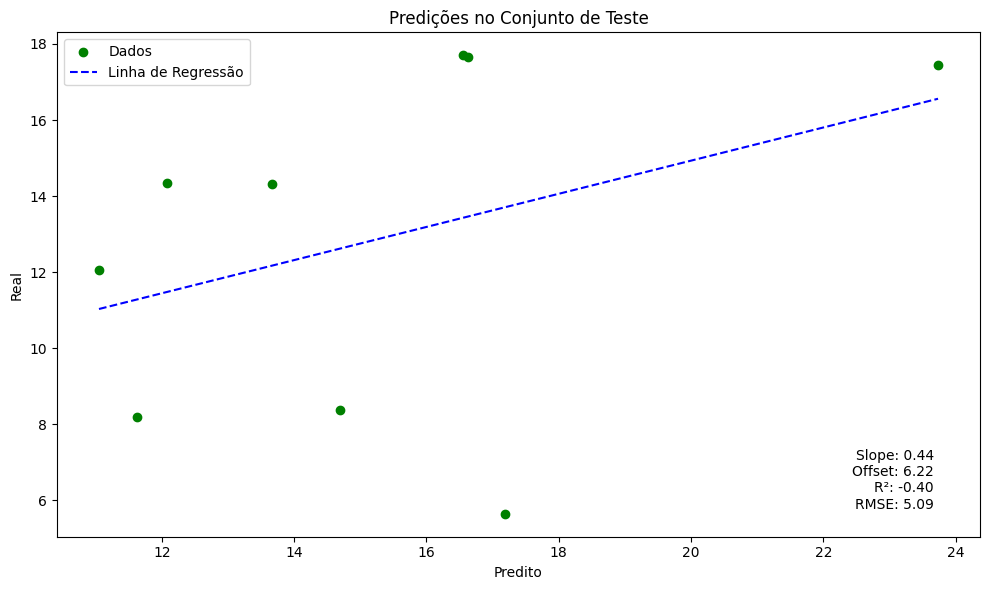

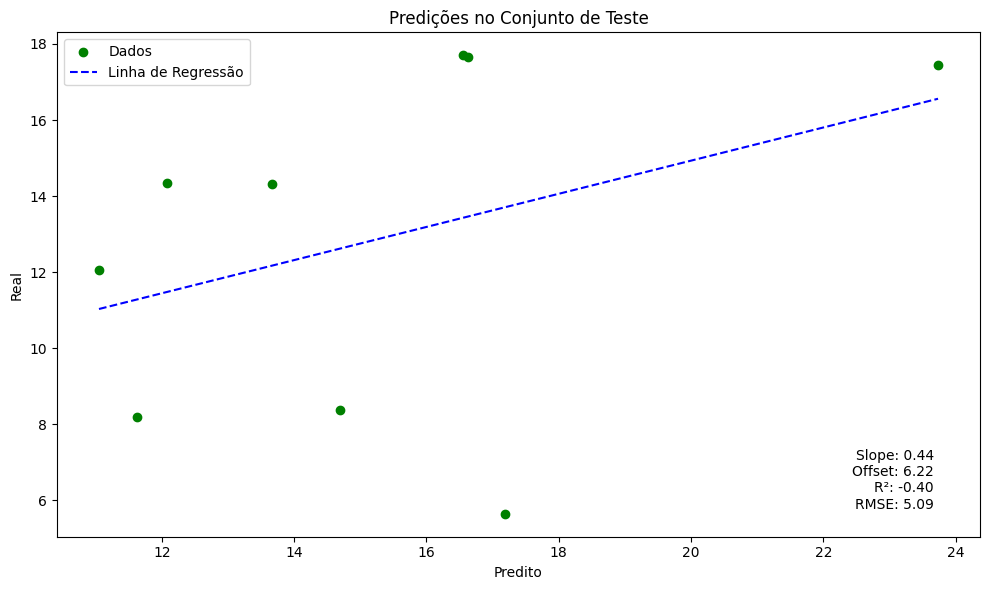

In [31]:
calibration_raw_aac, validation_raw_aac, Y_predict_raw_aac, plot_infos = build_model(df_raw_cal, df_raw_cal['% AAC'], df_raw_val, df_raw_val['% AAC'])

plot_infos_raw = add_plot_infos(plot_infos_raw, plot_infos, '% AAC')

Número de componentes: 10


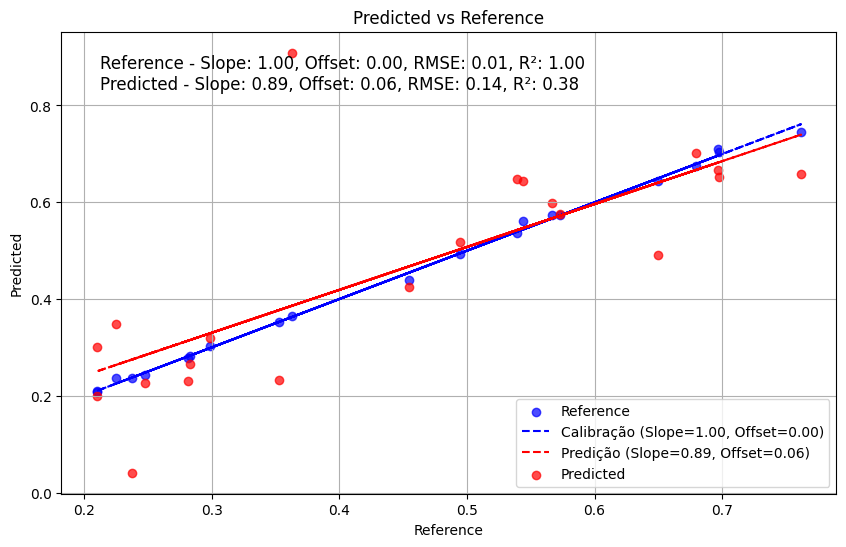

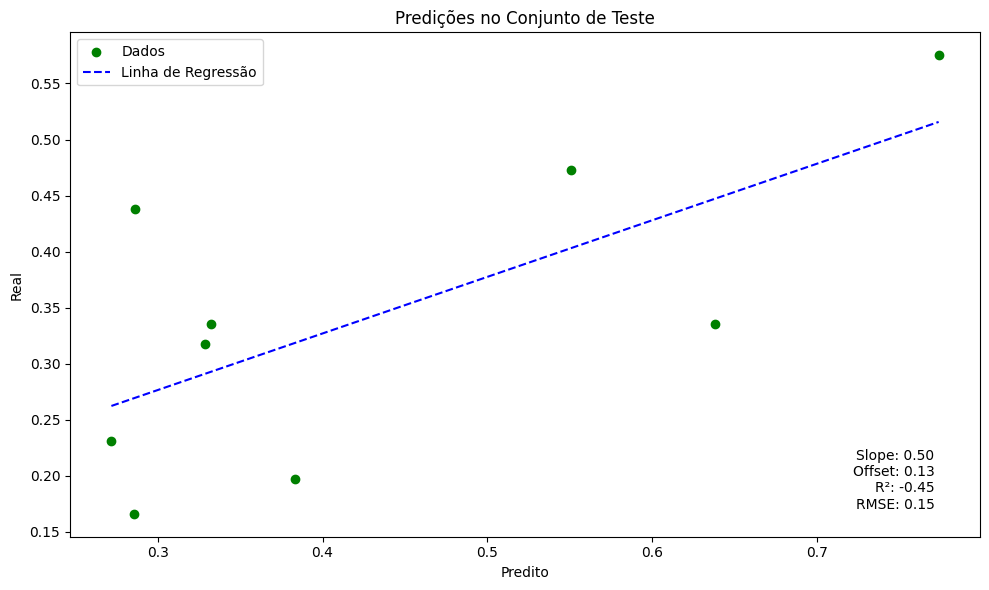

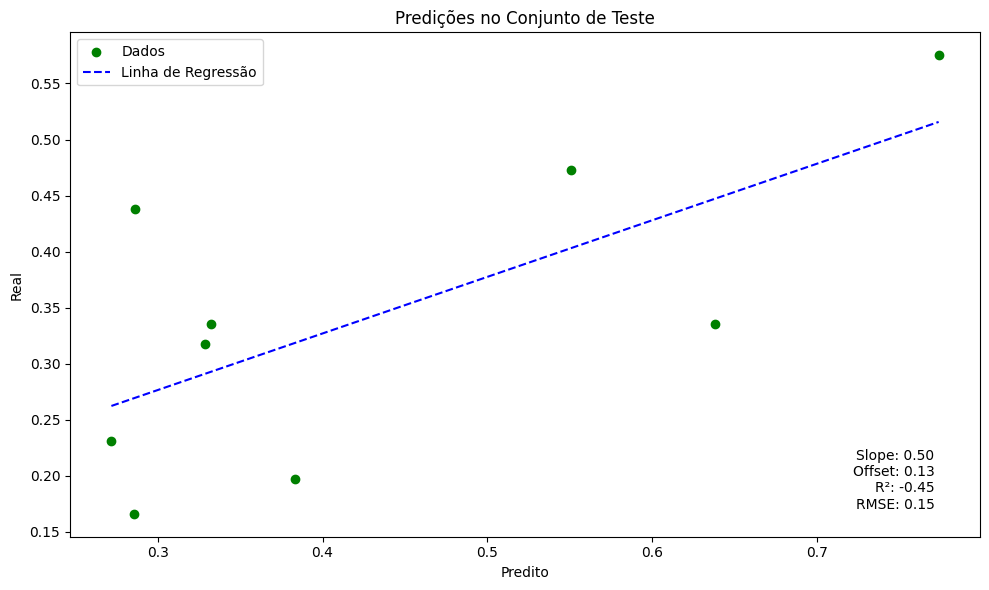

In [32]:
calibration_raw_att, validation_raw_att, Y_predict_raw_att, plot_infos = build_model(df_raw_cal, df_raw_cal['(ATT)'], df_raw_val, df_raw_val['(ATT)'])

plot_infos_raw = add_plot_infos(plot_infos_raw, plot_infos, '(ATT)')

Número de componentes: 5


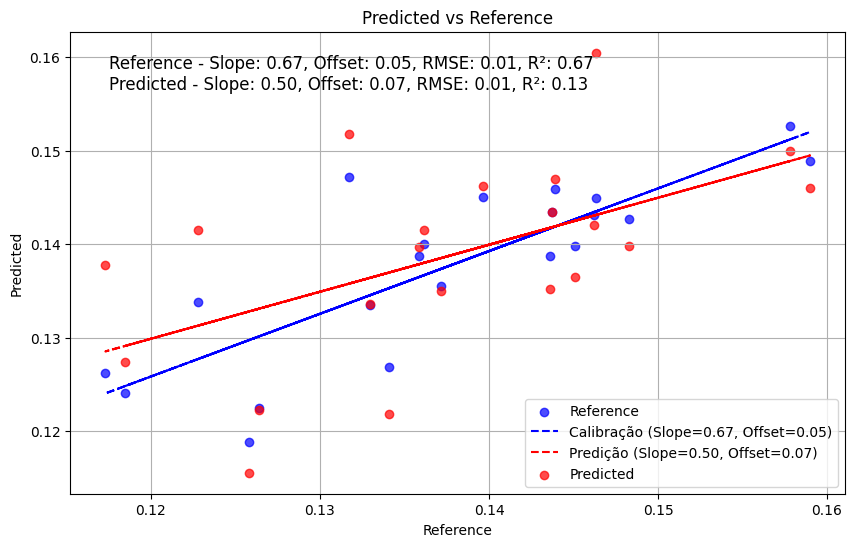

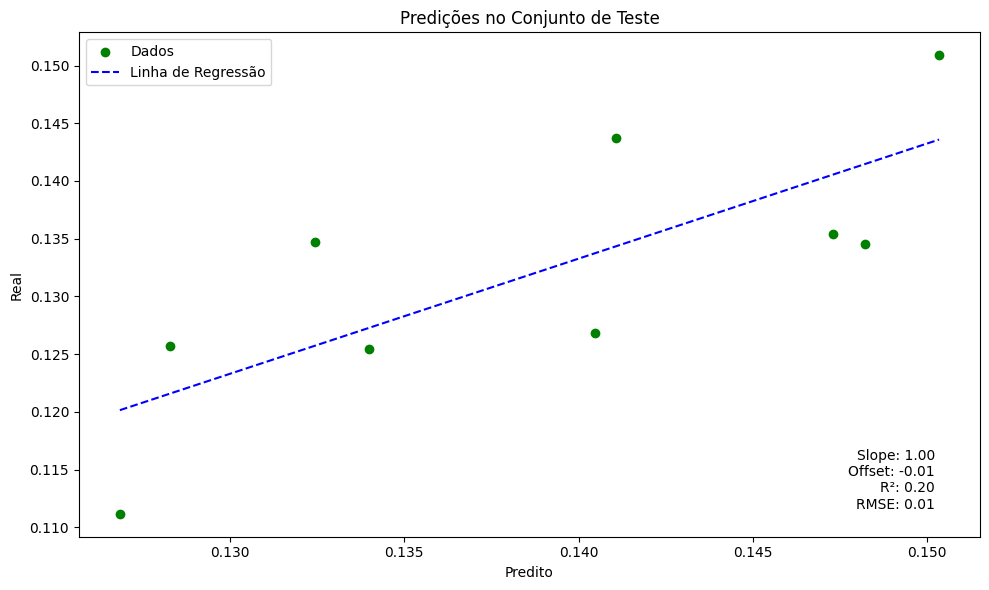

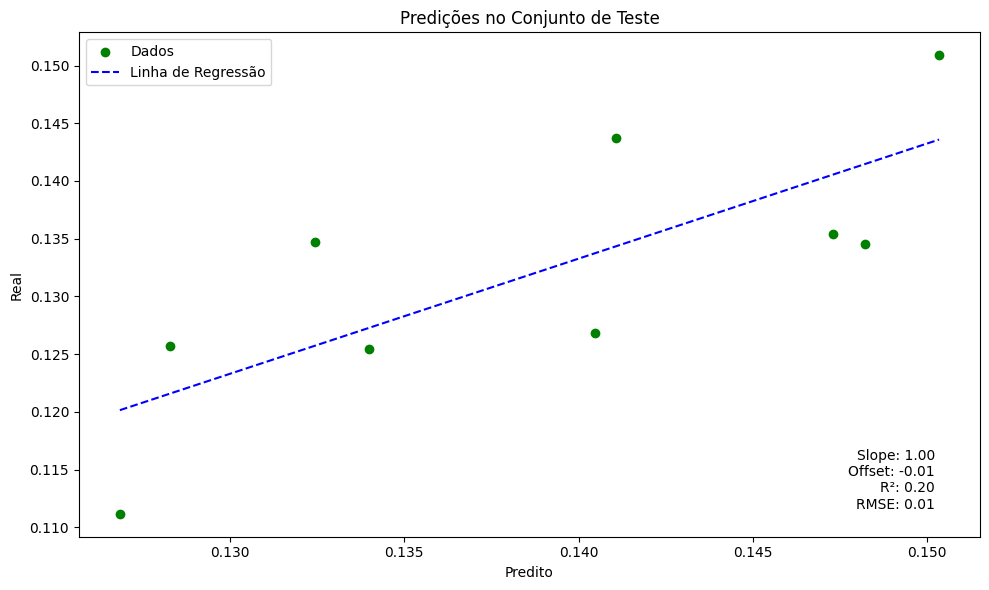

In [33]:
calibration_raw_ubs, validation_raw_ubs, Y_predict_raw_ubs, plot_infos = build_model(df_raw_cal, df_raw_cal['massa seca(%)'], df_raw_val, df_raw_val['massa seca(%)'])

plot_infos_raw = add_plot_infos(plot_infos_raw, plot_infos, 'massa seca(%)')

In [34]:
plot_infos_raw.to_excel('plot_infos_plsr_raw.xlsx', index=False)
plot_infos_raw

,Attribute,Y,R²,RMSE,Offset,Slope
0,BRIX,Referência,0.973230,0.282738,0.278595,0.973230
1,BRIX,Predição,-1.350487,2.649370,3.489495,0.636130
2,BRIX,Validação,-5.355160,1.634959,13.891007,-0.281482
3,FIRMNESS,Referência,0.994597,3.882313,0.355870,0.994597
4,FIRMNESS,Predição,0.885380,17.881494,3.083521,0.937309
5,FIRMNESS,Validação,0.839766,18.988831,-23.613246,1.305068
6,% AAC,Referência,0.958329,1.188269,0.652100,0.958329
7,% AAC,Predição,-0.709872,7.611638,5.993259,0.532644
8,% AAC,Validação,-0.402352,5.090672,6.217961,0.435756
9,(ATT),Referência,0.998107,0.007984,0.000844,0.998107
